In [86]:
import csv
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import plotly.express as px
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split #splitting the dataset
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix,r2_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score,precision_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
#from sklearn.metrics import classification_report,plot_precision_recall_curve, average_precision_score, precision_recall_curve
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu, normaltest
#!pip install statannotations
from statannotations.Annotator import Annotator
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from bioinfokit.visuz import cluster
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from IPython.display import Image
#from pydotplus import graph_from_dot_data
from sklearn.feature_selection import SelectFromModel
#from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import KFold
import pickle
import joblib
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.optimize import curve_fit
import optuna
from scipy.stats import sem, t
#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from xgboost import XGBClassifier
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
#Python standard libraries
import time
from tabpfn import TabPFNClassifier
import warnings
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 300
%matplotlib inline


In [87]:
#data imports
data_train_df = pd.read_csv("../../IDT_Reps_BED_BAM_TPFP_Final_01312023.csv")

#data_test_df = pd.read_csv("rearranged_annotated_fixed_sorted_NGS82-VE070_dedup.combined.metrics.csv")

In [88]:
#create the class labels
data_train_df = data_train_df[~data_train_df['eight_and_GIAB'].isna()]
data_train_df = data_train_df.fillna(0)
data_train_df = data_train_df.reset_index(drop=True)
data_train_df['Class'] = data_train_df['eight_and_GIAB'].map({True : 0, False: 1})
data_train_df.Class.value_counts()

0    34772
1     5697
Name: Class, dtype: int64

In [89]:
#balance the data
class_0_df = data_train_df[data_train_df['Class'] == 0]
class_1_df = data_train_df[data_train_df['Class'] == 1]
min_class_size = min(len(class_0_df), len(class_1_df))
class_0_sampled = class_0_df.sample(n=min_class_size, random_state=42)
class_1_sampled = class_1_df.sample(n=min_class_size, random_state=42)
balanced_df = pd.concat([class_0_sampled, class_1_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Class'].value_counts())

0    5697
1    5697
Name: Class, dtype: int64


In [110]:
#select only number columns and filter by variance threshold


def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

data_only_df = balanced_df.select_dtypes(include=np.number)

cols_to_remove = ['raw_dp_std', 'raw_dp_min', 'raw_dp_median',
                  'normalized_raw_dp_mean', 'normalized_raw_dp_std',
                  'normalized_raw_dp_min', 'normalized_raw_dp_median',
                  'count_mapq_Lt10_std', 'count_mapq_Lt10_min',
                  'count_mapq_Lt10_median', 'pct_count_mapq_Lt10_std','homology_mean', 
                  'homology_min', 'homology_median',
                  'pct_count_mapq_Lt10_min', 'pct_count_mapq_Lt10_median',
                  'homology_std', 'homology_max',"NGS82_Homolgy_Probes_V2.PO",
                  "NGS82_Homolgy_Probes_V2.RPO",
                  "proper_pair_std", "proper_pair_mean",  "proper_pair_min",
                  "isize_min", "mm-2-merged-complement.PO",
                  "mm-2-merged-complement.RPO",'mm-2-merged.PO', 'mm-2-merged.RPO',
                 'isize_max', 'AS_max', 'MQ_max', 'normalized_raw_dp_max', 'count_mapq_Lt10_max']

data_only_df = data_only_df.drop(cols_to_remove, axis=1)
var_thr = VarianceThreshold(threshold=0.05)
data_only_filtered_df = data_only_df.loc[:, var_thr.fit(data_only_df).get_support()]
labels = data_only_filtered_df['Class']
data_cols_df = data_only_filtered_df.drop(columns=['Class'])
data_filtered_df = correlation(data_cols_df, 0.9)
model_cols = data_filtered_df.columns
data_filtered_df

,isize_mean,isize_median,MAPQ_mean,MAPQ_std,AS_mean,AS_std,XS_mean,XS_std,MQ_std,raw_dp,...,Mandelkar_highstringency.PO,Mandelkar_lowstingency.PO,NCBI_NGS_dead_zone.PO,notinAllRepeats_gt95percidentity_slop5.PO,notinsegdupall.PO,PacBio_MetaSV_mergedSVs.PO,phastConsElements100way.RPO,PhastConsElements100way.RPO,refseq_union_cds.PO,refseq_union_cds.RPO
0,235.000000,234.0,60.000000,0.000000,147.666667,2.886751,20.000000,0.000000,0.0,595.000000,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.0,0.000,0.000
1,97.666667,103.0,60.000000,0.000000,147.666667,2.886751,20.666667,0.577350,0.0,1255.333333,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,1.0,1.000,0.019
2,146.000000,132.0,60.000000,0.000000,151.000000,0.000000,20.000000,0.000000,0.0,345.000000,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,1.0,0.000,0.000
3,234.000000,235.0,60.000000,0.000000,144.000000,2.645751,20.000000,0.000000,0.0,826.000000,...,0.000,0.000,0.0,0.417,1.0,0.000,0.000,1.0,0.542,0.504
4,178.166667,163.5,60.000000,0.000000,150.666667,0.577350,27.666667,2.081666,0.0,722.000000,...,0.000,0.000,0.0,0.312,1.0,0.000,0.659,1.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11389,66.500000,95.5,45.333333,4.618802,146.000000,0.000000,127.000000,1.000000,0.0,3579.666667,...,0.000,0.504,0.0,0.000,0.0,0.667,0.000,0.6,0.000,0.000
11390,134.000000,121.0,60.000000,0.000000,144.000000,1.732051,19.000000,0.000000,0.0,939.666667,...,0.000,0.000,0.0,1.000,1.0,0.000,1.000,1.0,0.000,0.000
11391,127.000000,118.0,60.000000,0.000000,146.000000,0.000000,21.000000,0.000000,0.0,986.666667,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.0,0.000,0.000
11392,139.666667,129.0,60.000000,0.000000,146.000000,0.000000,19.000000,0.000000,0.0,1113.333333,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.8,1.000,0.242


In [111]:
name_change_dict = {'GRCh37_SimpleRepeat_homopolymer_7to11_slop5.RPO' : "NIST_SR_HP_7t11_slop5.RPO",
       'GRCh37_notinsegdups.PO':"NIST_notSD.PO",
       'GRCh37_AllTandemRepeatsandHomopolymers_slop5.RPO':"NIST_ATRH_slop5.RPO",
       'hg19_self_chain_split_both.PO': "NIST_SCSB.PO",
       'AllRepeats_lt51bptandemrepeats_gt95identity_merged_slop5.RPO': "AR_lt51TB_gt95_slop5.PRO",
       'human_g1k_v37_l100_gc55to60_slop50.PO':"gc55to60_slop50.PO",
       'human_g1k_v37_l100_gclt30orgt55_slop50.PO': "gclt30orgt55_slop50.PO",
       'GRCh37_notinlowmappabilityall.PO': "NIST_notinLM.PO",
        'GRCh37_gc65to70_slop50.PO': "NIST_gc65to70_slop50.PO",
       'siren_similarRegions_dist1.PO': "Siren.PO", 
       'human_g1k_v37_l100_gclt25orgt65_slop50.PO': "gclt25orgt65_slop50.PO",
       'GRCh37_notinAllTandemRepeatsandHomopolymers_slop5.PO': "NIST_NIATRH_slop5.PO", 
       'GRCh37_alldifficultregions.PO': "NIST_alldifficultregions.PO",
       'GRCh37_alldifficultregions.RPO': "NIST_alldifficultregions.RPO",
       'GRCh37_notinalllowmapandsegdupregions.PO': "NIST_NIALMSDR.PO", 
       'refseq_union_cds_no_anno.PO': "refseq_CDS.PO",
        'refseq_union_cds_no_anno.RPO': "refseq_CDS.RPO",
       'GRCh37_SimpleRepeat_homopolymer_4to6_slop5.RPO': "NIST_SRH4to6_slop5.RPO",
       'GRCh37_chainSelf_gt10kb.PO': "NIST_chain_gt10KB.PO",
        'SimpleRepeat_homopolymer_6to10.RPO': "SR_HP_6to10.RPO",
       'hg19_self_chain_split_both_gt10k.PO': "hg19_SCSB_gt10K.PO",
        'GRCh37_gclt25orgt65_slop50.PO': "NIST_gclt25orgt65_slop50.PO",
       'SimpleRepeat_imperfecthomopolgt10_slop5.RPO': "SR_Ihpgt10_slop5.RPO",
       'GRCh37_AllHomopolymers_gt6bp_imperfectgt10bp_slop5.RPO': "NIST_Ahp_gt6_igt10bp_splop5.RRO",
       'GRCh37_notinalldifficultregions.PO': "NIST_naDiffreg.PO",
       'human_g1k_v37_l100_gc30to55_slop50.PO': "gc30to55_slop50.PO",
       'GRCh37_gclt30orgt55_slop50.PO': "NIST_gclt30orgt55_slop50.PO",
       'human_g1k_v37_l100_gc65to70_slop50.PO' : "gc65to70_slop50.PO",
       'GRCh37_alllowmapandsegdupregions.PO': "NIST_LowSegDupReg.PO",
       'hg19_self_chain_split_withalts_gt10k.PO': "split_withalts_gt10k.PO",
       'notinAllRepeats_gt95percidentity_slop5.PO': "NotinRep_gt95_slop5.PO",
       'AllRepeats_gt95percidentity_slop5.RPO': "AllRep_gt95iden_slop5.RPO",
       'AllRepeats_lt51bp_gt95identity_merged_slop5.RPO': "AllRep_lt51_gt95iden_slop5.RPO",
       'AllRepeats_lt51bp_gt95identity_merged.RPO': "AllRep_lt51_gt95iden.RPO",
       'AllRepeats_lt51bptandemrepeats_gt95identity_merged.RPO': "AllRep_lt51tandemgt95.RPO",
       'human_g1k_v37_l100_gc60to65_slop50.PO': "gc60to65_slop50.PO", 
       'GRCh37_SimpleRepeat_imperfecthomopolgt10_slop5.RPO': "NIST_SR_impHomo10_slop5.RPO",
        'GRCh37_allOtherDifficultregions.PO': 'NIST_allOthDiffReg.PO',
        'human_g1k_v37_gemmap_l150_m2_e1_nonuniq.PO': 'gen_l150_m2_e1_nonuniq.PO', 
        'GRCh37_AllTandemRepeats_gt100bp_slop5.PO': "NIST_ATRep_gt100bp_slop5.PO",
        'human_g1k_v37_gemmap_l150_m1_e0_nonuniq.PO': 'gen_l150_m1_e0_nonuniq.PO',
        'GRCh37_AllTandemRepeatsandHomopolymers_slop5.PO':'NIST_ATrepHomo_slop5.PO',
        'human_g1k_v37_gemmap_l100_m1_e0_nonuniq.PO': 'gen_l100_m1_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m1_e0_nonuniq.PO': 'gen_l250_m1_e0_nonuniq.PO',
         'Human_Full_Genome_TRDB_hg19_150331_all_merged.PO':'hg19_150331_all_merged.PO', 
        'human_g1k_v37_gemmap_l100_m0_e0_nonuniq.PO':"gen_l100_m0_e0_nonuniq.PO",
        'GRCh37_SimpleRepeat_homopolymer_gt11_slop5.RPO':'NIST_SRhomogt11_slop5.RPO',
        'human_g1k_v37_gemmap_l150_m2_e0_nonuniq.PO':'gen_l150_m2_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m2_e1_nonuniq.PO':'gen_l250_m2_e1_nonuniq.PO',
        'human_g1k_v37_gemmap_l100_m2_e1_nonuniq.PO':"gen_l100_m2_e1_nonuniq.PO",
         'human_g1k_v37_gemmap_l100_m2_e0_nonuniq.PO':"gen_l100_m2_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m2_e0_nonuniq.PO':"gen_l125_m2_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m0_e0_nonuniq.PO':'gen_l125_m0_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m2_e0_nonuniq.PO':'gen_l250_m2_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l150_m0_e0_nonuniq.PO':"gen_l150_m0_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m2_e1_nonuniq.PO':'gen_l125_m2_e1_nonuniq.PO',
        'human_g1k_v37_gemmap_l125_m1_e0_nonuniq.PO':'gen_l125_m1_e0_nonuniq.PO'
                   }

In [119]:
#Transform the data for learning
def preprocess_data(df, labels, test_size=0.1, val_size=0.1, random_state=42):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_df = pd.DataFrame(min_max_scaler.fit_transform(df.values),
                              columns=df.columns, index=df.index)

    X = scaled_df.values
    y = labels.values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    
    return X, X_train, X_val, X_test, y, y_train, y_val, y_test

X, X_train, X_val, X_test, y, y_train, y_val, y_test = preprocess_data(data_filtered_df, labels)
print("Number of samples in dataset:", len(X))
print("Number of samples in training set:", len(X_train))
print("Number of samples in validation set:", len(X_val))
print("Number of samples in testing set:", len(X_test))


Number of samples in dataset: 11394
Number of samples in training set: 9228
Number of samples in validation set: 1026
Number of samples in testing set: 1140


In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LatentSpaceGaussian:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.latent_params = 2 * latent_dim

    def get_latent_params(self, x):
        x = x.view(-1, 2, self.latent_dim)
        mu, log_var = x[:, 0, :], x[:, 1, :]
        return mu, log_var

    def sample_latent(self, latent_params):
        mu, log_var = latent_params
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def kl_loss(self, latent_params):
        mu, log_var = latent_params
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return kl_div / mu.shape[0]


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.stop = False

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.stop = True


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, grad_clip=10, latent_limit=10.0):
        super(Encoder, self).__init__()
        self.enc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.enc2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.grad_clip = grad_clip
        self.latent_limit = latent_limit

    def forward(self, inp):
        x = self.enc1(inp)
        if x.requires_grad:
            x.register_hook(lambda x: x.clamp(min=-self.grad_clip, max=self.grad_clip))
        x = F.relu(x)
        x = self.enc2(x)
        if x.requires_grad:
            x.register_hook(lambda x: x.clamp(min=-self.grad_clip, max=self.grad_clip))
        x = torch.tanh(x) * self.latent_limit
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim, hidden_size=27, dropout_p=0.2):
        super(Decoder, self).__init__()
        self.dec1 = nn.Linear(in_features=latent_dim, out_features=hidden_size)
        self.dec2 = nn.Linear(in_features=hidden_size, out_features=input_dim * 2)  # Output dimension * 2 for mean and std
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, z):
        x = F.relu(self.dec1(z))
        x = self.dropout(x)
        x = self.dec2(x)
        return x.view(-1, 2, x.size(1) // 2)


        
class VariationalAutoencoder(nn.Module):
    def __init__(self, params):
        super(VariationalAutoencoder, self).__init__()
        
        self.input_dim = params['input_dim']        
        self.latent_dim = params['latent_dim']
        self.hidden_size = params['hidden_size']
        self.early_stop = params['early_stop']
        
        self.latent_space = LatentSpaceGaussian(self.latent_dim)
        self.encoder = Encoder(input_dim=self.input_dim, hidden_dim=self.hidden_size, output_dim=self.latent_space.latent_params)
        self.decoder = Decoder(latent_dim=self.latent_dim, input_dim=self.input_dim, hidden_size=self.hidden_size)
        
        if self.early_stop:
            self.early_stopper = EarlyStopper(patience=30, min_delta=2)
        
        self.kl_w = 1

    def forward(self, input_data):
        latent_output = self.encoder(input_data)
        latent_params = self.latent_space.get_latent_params(latent_output)
        z = self.latent_space.sample_latent(latent_params)
        cov_params = self.decoder(z)
        return {'z': z, 'cov_params': cov_params, 'latent_params': latent_params}


    def reconstruction_loss(self, recon_params, true_data):
        mean = recon_params[:, 0]
        std = recon_params[:, 1]
        std = torch.clamp(std, min=1e-10)  # Prevent division by zero
        recon_loss = -torch.log(std) - 0.5 * ((true_data - mean) ** 2) / (std ** 2)
        return -torch.mean(recon_loss)

    def fit_epoch(self, data, optimizer, batch_size=64, device=torch.device('cpu')):
        epoch_results = {'loss_train': 0.0, 'loss_val': 0.0}
        cov_train, mask_train, cov_val, mask_val = data
        
        cov_val = torch.from_numpy(cov_val).to(device).float()
        mask_val = torch.from_numpy(mask_val).to(device).float()
        
        n_batches = int(np.ceil(cov_train.shape[0] / batch_size))
        for batch in range(n_batches):
            index_init = batch * batch_size
            index_end = min((batch + 1) * batch_size, cov_train.shape[0])
            cov_train_batch = cov_train[index_init: index_end]
            mask_train_batch = mask_train[index_init: index_end]

            self.train()
            cov_train_batch = torch.from_numpy(cov_train_batch).to(device).float()
            mask_train_batch = torch.from_numpy(mask_train_batch).to(device).float()
            
            out = self(cov_train_batch)
            latent_params = out['latent_params']
            cov_params = out['cov_params']
            
            optimizer.zero_grad()
            loss_kl = self.latent_space.kl_loss(latent_params)
            loss_cov = self.reconstruction_loss(cov_params, cov_train_batch)
            loss = loss_kl + loss_cov
            loss.backward()
            optimizer.step()
            
            epoch_results['loss_train'] += loss.item()
            
            self.eval()
            with torch.no_grad():
                out = self(cov_val)
                latent_params = out['latent_params']
                cov_params = out['cov_params']
                loss_kl = self.latent_space.kl_loss(latent_params)
                loss_cov = self.reconstruction_loss(cov_params, cov_val)
                loss = loss_kl + loss_cov

                epoch_results['loss_val'] += loss.item()

        if self.early_stop:
            self.early_stopper.early_stop(epoch_results['loss_val'])
        
        return epoch_results

    def fit(self, data, train_params):
        training_stats = {'loss_train': [], 'loss_val': []}
        optimizer = torch.optim.Adam(self.parameters(), lr=train_params['lr'])
        latent_space_distribution = []
        
        for epoch in range(train_params['n_epochs']):
            x_train, mask_train, x_val, mask_val = data
            assert mask_train.shape == x_train.shape
            assert mask_val.shape == x_val.shape
            ep_data = np.array(x_train), np.array(mask_train), np.array(x_val), np.array(mask_val)
            epoch_results = self.fit_epoch(ep_data, optimizer, batch_size=train_params['batch_size'], device=train_params['device'])
            latent_space_distribution = [] 

            with torch.no_grad():
                x_train_tensor = torch.from_numpy(np.array(data[0])).to(train_params['device']).float()
                latent_output = self.encoder(x_train_tensor)
                latent_params = self.latent_space.get_latent_params(latent_output)
                z = self.latent_space.sample_latent(latent_params)
                latent_space_distribution.append(z.cpu().numpy())
                
            for key in epoch_results.keys():
                training_stats[key].append(epoch_results[key])


            if self.early_stop and self.early_stopper.stop:
                print('EARLY STOP')
                break
        
        return training_stats, latent_space_distribution 

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()


input_size = X_train.shape[1]
hidden_size = 64  # Adjust as needed
latent_dim = 1


params = {
    'input_dim': input_size,
    'latent_dim': latent_dim,
    'hidden_size': hidden_size,
    'early_stop': True,
}

# Create the model
model = VariationalAutoencoder(params)

# Define training parameters
train_params = {
    'n_epochs': 300,  # Adjust the number of epochs as needed
    'batch_size': 64,  # Adjust the batch size as needed
    'lr': 0.001,  # Learning rate
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
}


mask_train = np.ones_like(X_train)
mask_val = np.ones_like(X_val)

# Prepare the data
data = (X_train, mask_train, X_val, mask_val)

# Move model to the appropriate device
model.to(train_params['device'])

# Train the model
training_stats, latent_space_distribution = model.fit(data, train_params)

# Print training stats
print(pd.DataFrame(training_stats))


EARLY STOP
       loss_train      loss_val
0    2.305074e+20  1.476635e+20
1    2.741279e+19  3.153702e+18
2    1.461412e+19  7.314143e+17
3    9.546429e+18  4.597811e+16
4    6.156882e+18  7.968831e+02
..            ...           ...
195  1.118561e+14 -5.262653e+01
196  8.248988e+14 -5.303703e+01
197  8.449194e+13 -5.330572e+01
198  6.247442e+15 -5.418910e+01
199  1.690714e+16 -5.534816e+01

[200 rows x 2 columns]


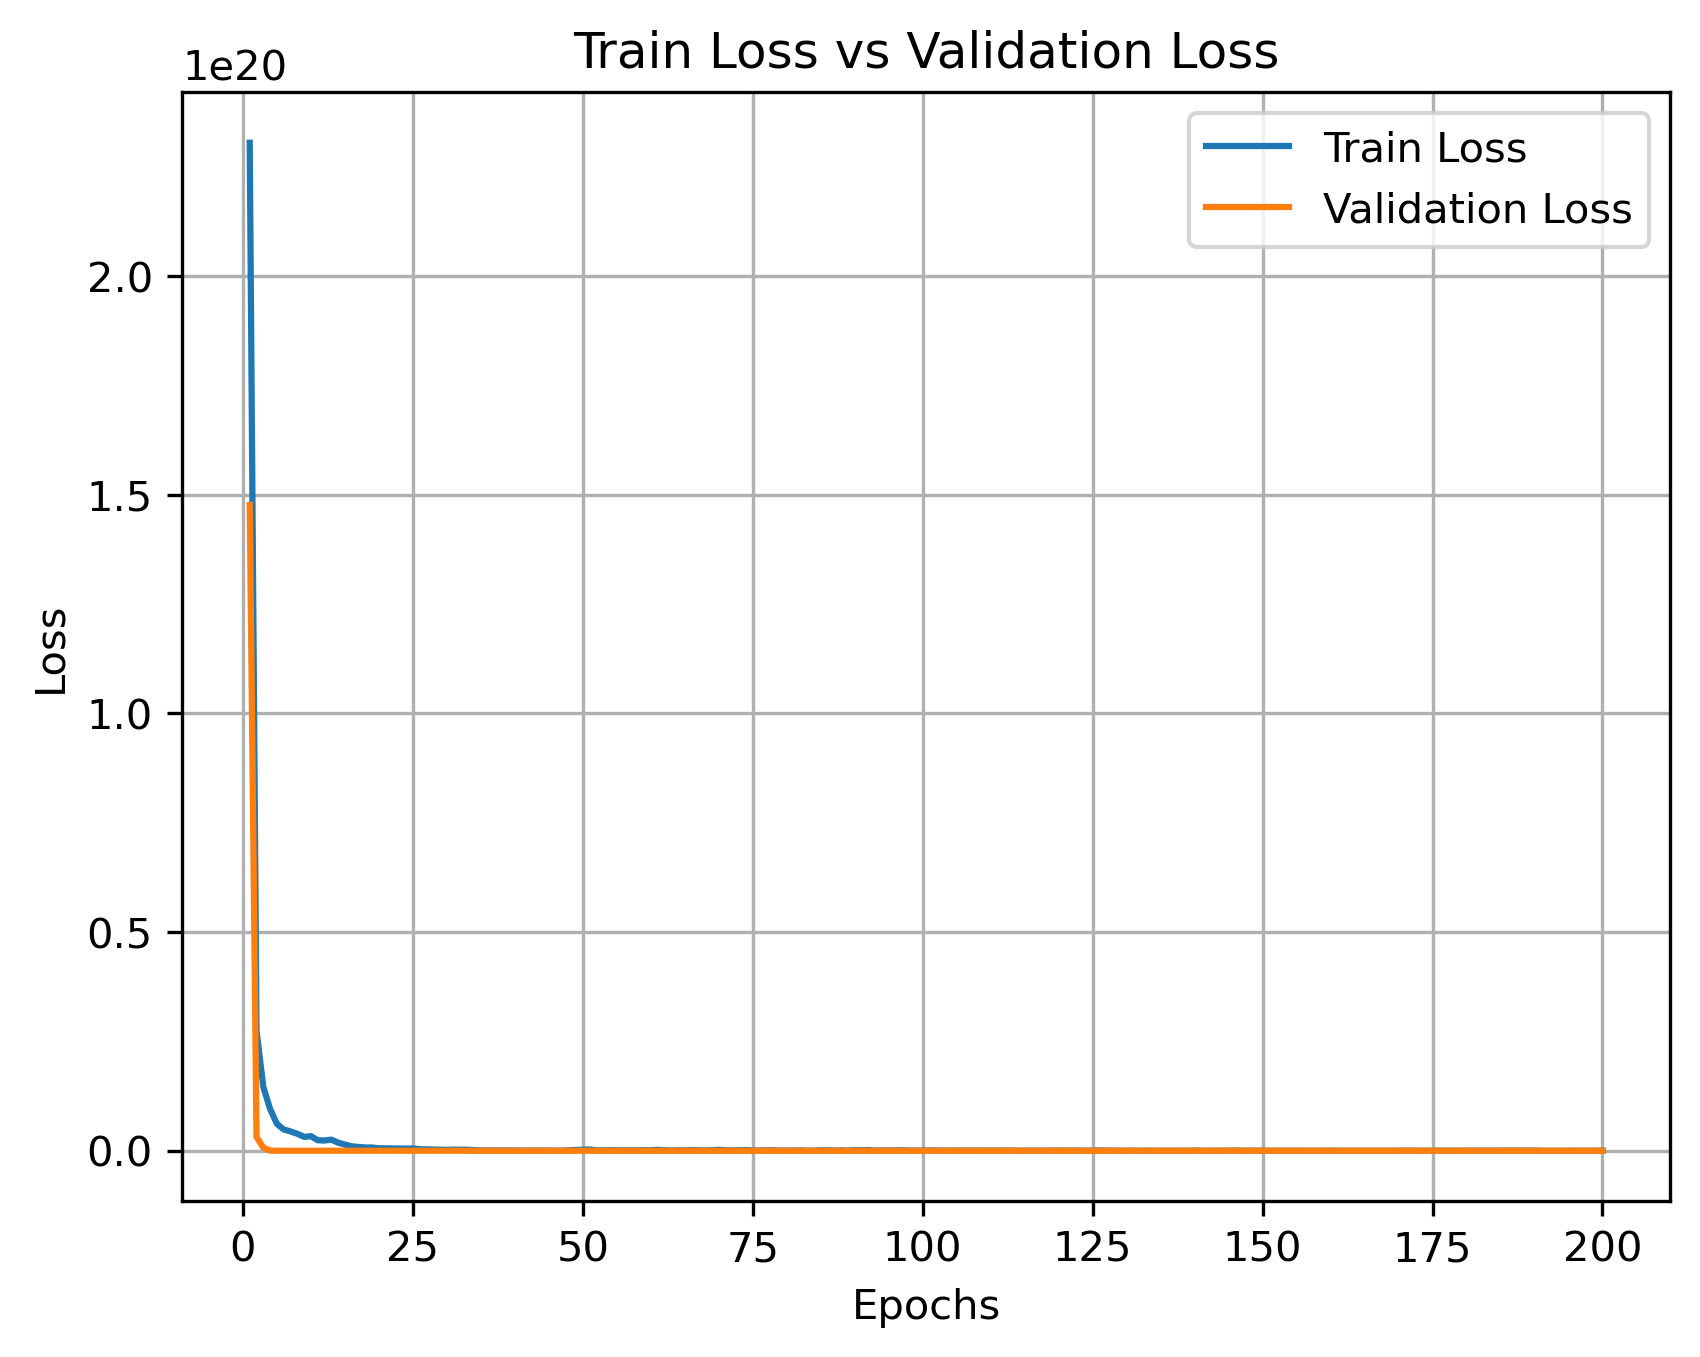

In [130]:
vae_results_bs64_lr001_df =pd.DataFrame(training_stats)
vae_results_bs64_lr001_df['epochs'] = vae_results_bs64_lr001_df.index + 1
epochs = vae_results_bs64_lr001_df.epochs.tolist()
loss_train = vae_results_bs64_lr001_df.loss_train.tolist()
loss_val = vae_results_bs64_lr001_df.loss_val.tolist()
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

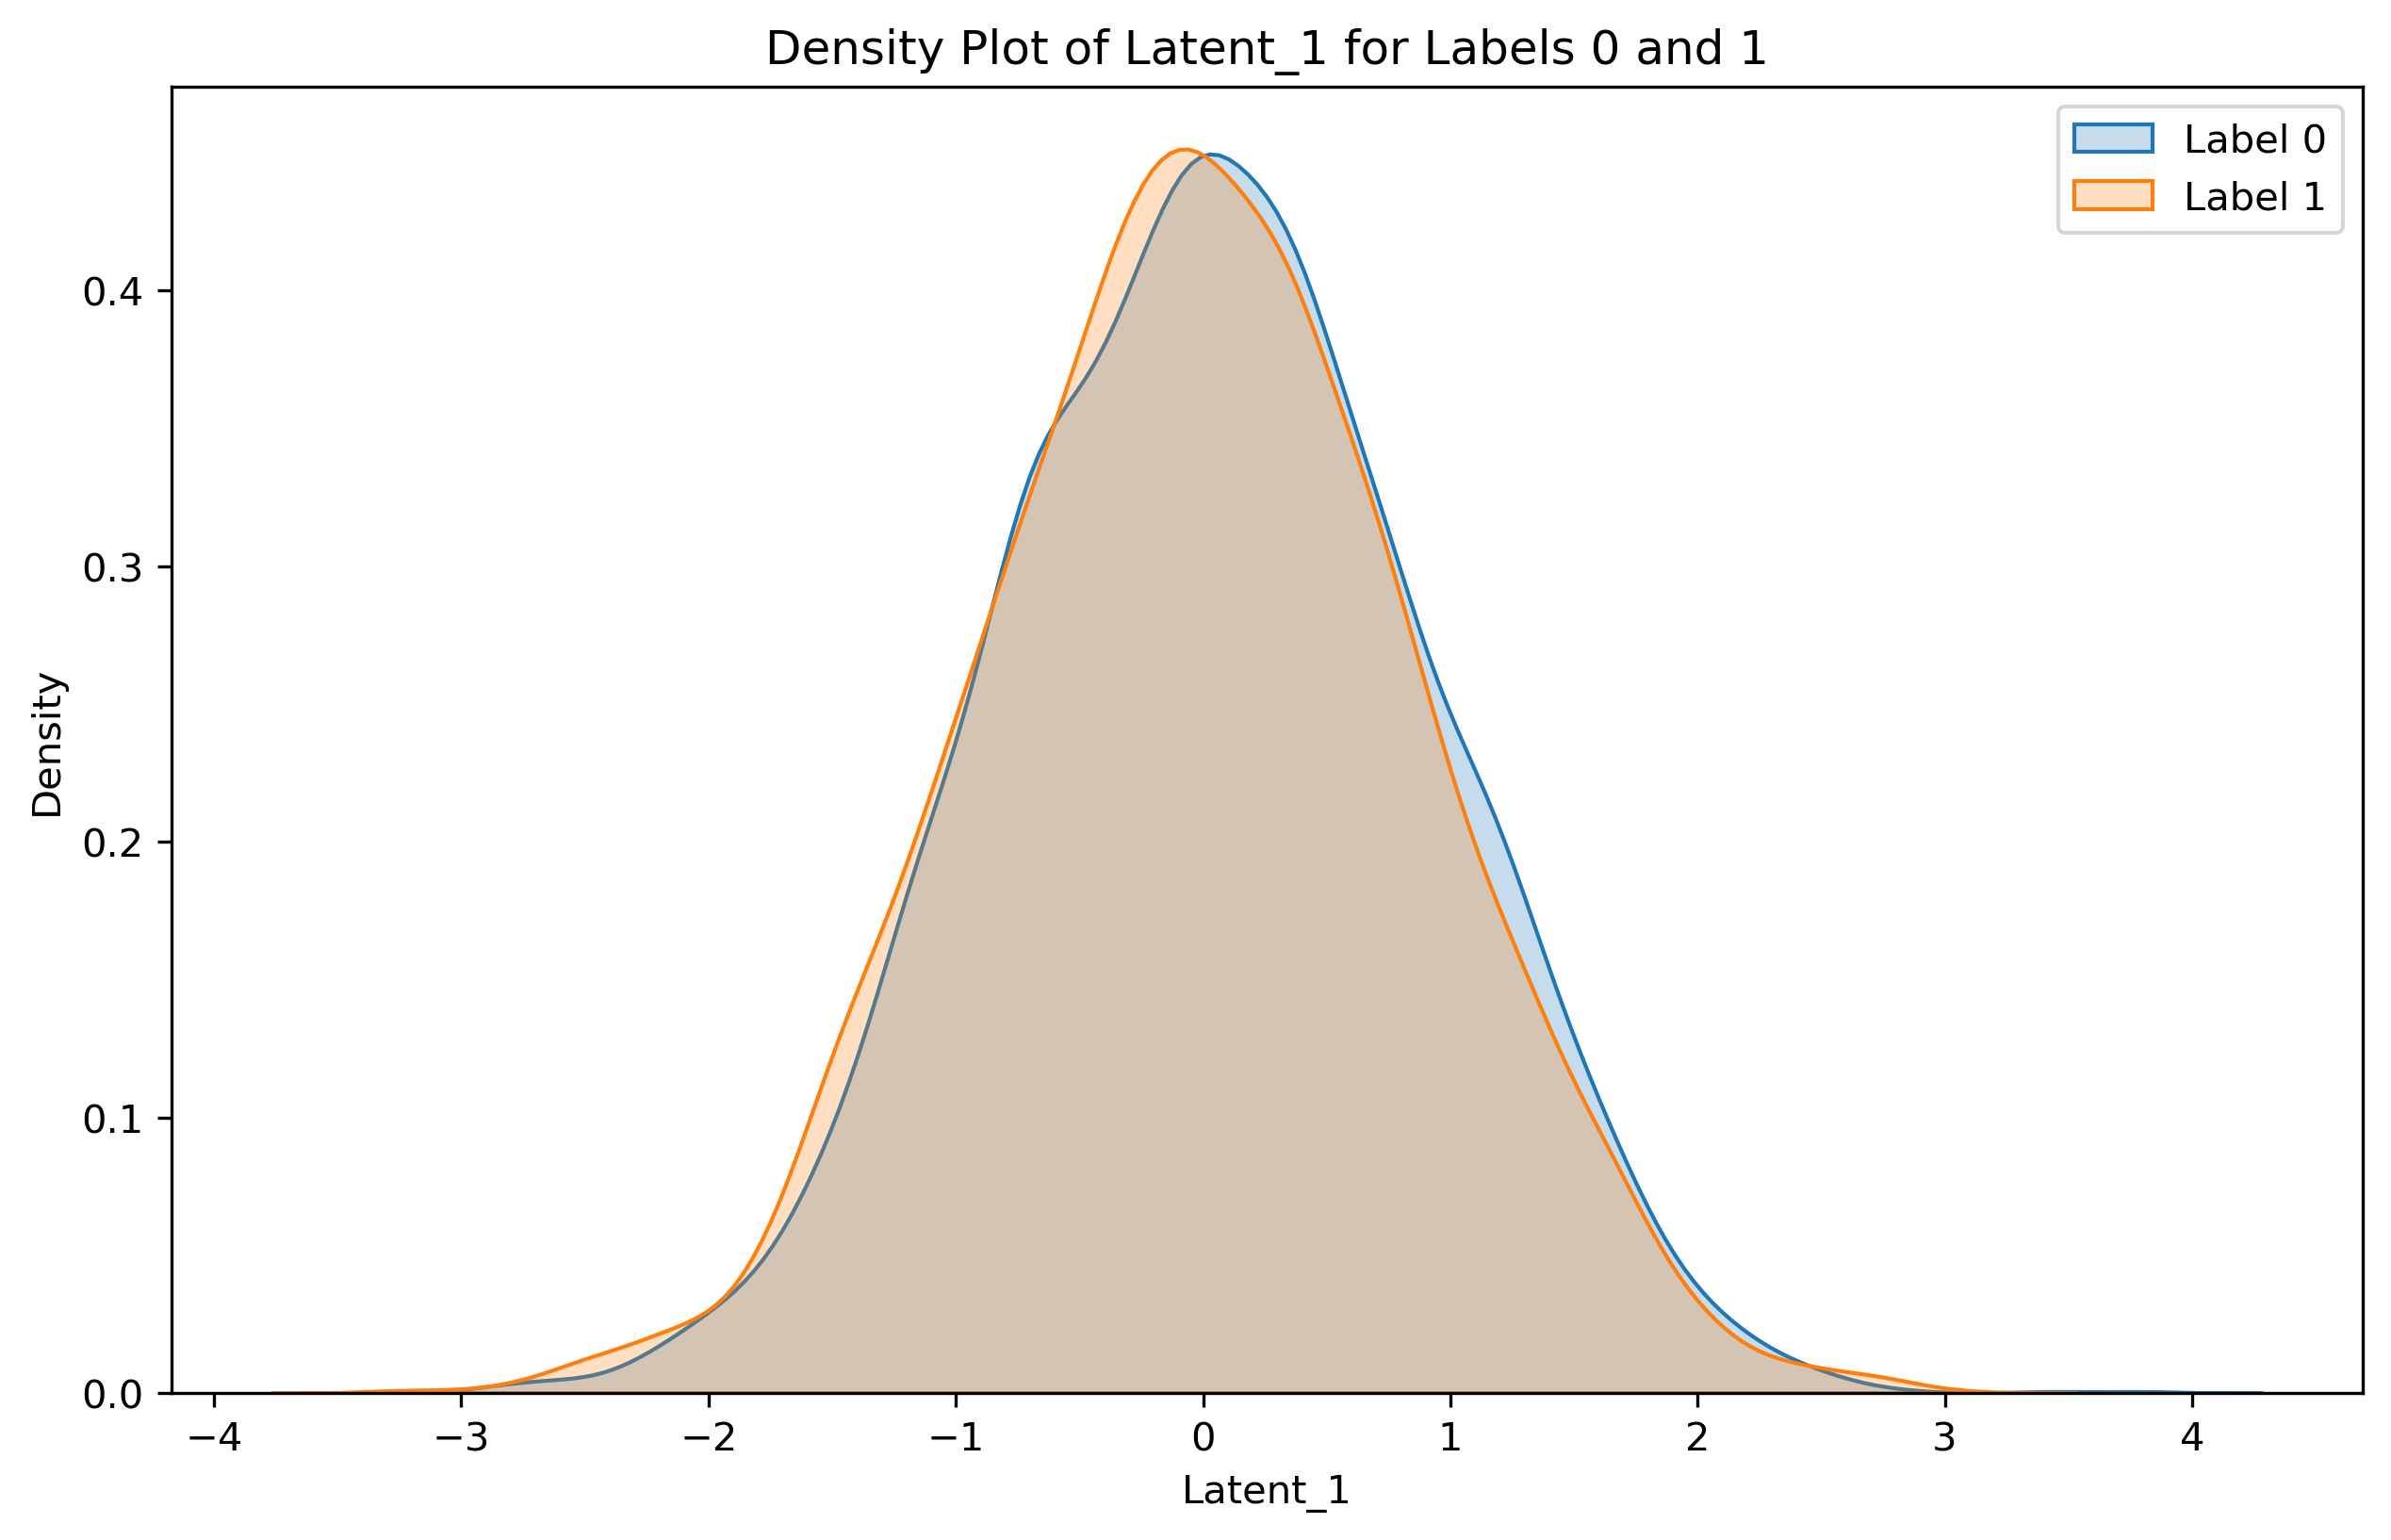

In [136]:
#latent_space_distribution
from mpl_toolkits.mplot3d import Axes3D
latent_space_distribution = np.array(latent_space_distribution)
#latent_space_distribution
latent_1 = latent_space_distribution[:, :, 0]
#latent_2 = latent_space_distribution[:, :, 1]

model_labels = y_train

# Scatter plot
#plt.scatter(latent_1.flatten(), latent_2.flatten(), c=labels.flatten(), cmap='viridis')
#plt.xlabel('Latent 1')
#plt.ylabel('Latent 2')
#plt.title('Scatter Plot of Latent Space')
#plt.colorbar(label='Labels')
#plt.show()

# Show plot
#plt.show()
latent_df = pd.DataFrame({
    'latent_1': latent_1.flatten(),
    'label': model_labels
})

# Plot the density distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=latent_df[latent_df['label'] == 0], x='latent_1', label='Label 0', fill=True)
sns.kdeplot(data=latent_df[latent_df['label'] == 1], x='latent_1', label='Label 1', fill=True)
plt.title('Density Plot of Latent_1 for Labels 0 and 1')
plt.xlabel('Latent_1')
plt.ylabel('Density')
plt.legend()
plt.show()

In [128]:
latent_space_distribution = np.array(latent_space_distribution).reshape(9228, 20)

# Create a DataFrame
columns = [f'latent_{i+1}' for i in range(latent_space_distribution.shape[1])]
latent_df = pd.DataFrame(latent_space_distribution, columns=columns)

# Add labels to the DataFrame
#latent_df['label'] = labels

# Display the DataFrame
latent_df

X_vae = latent_df.values
y_vae = y_train
    
    # Split the data into training and testing sets
X_vae_train, X_vae_test, y_vae_train, y_vae_test = train_test_split(X_vae, y_vae, test_size=0.2, random_state=42)


xgb_model = XGBClassifier()
xgb_model.fit(X_vae_train, y_vae_train)
xgb_pred_proba = xgb_model.predict_proba(X_vae_test)[:, 1]
xgb_auc, xgb_auc_ci, xgb_pr_auc, xgb_pr_auc_ci = calculate_auc_with_ci(y_vae_test, xgb_pred_proba)
print(xgb_auc, xgb_auc_ci, xgb_pr_auc, xgb_pr_auc_ci)

0.5261824969139287 (0.5236858499478494, 0.528679143880008) 0.4977775486055047 (0.4944499462085929, 0.5011051510024165)


In [14]:
class TabbPN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TabbPN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

    
def calculate_auc_with_ci(y_true, y_pred_proba):
    aucs = []
    pr_aucs = []
    n_bootstrap = 100
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        sample_true = y_true[idx]
        sample_pred_proba = y_pred_proba[idx]
        
        auc = roc_auc_score(sample_true, sample_pred_proba)
        aucs.append(auc)
        
        pr_auc = average_precision_score(sample_true, sample_pred_proba)
        pr_aucs.append(pr_auc)

    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci

# Preprocess data using TabbPN

# Train TabbPN model
def train_tabular_model(X_train, y_train, input_size, hidden_size, output_size, num_epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TabbPN(input_size, hidden_size, output_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

    return model

# Load and preprocess your data
#X_train, X_test, y_train, y_test = preprocess_tabular_data(data_filtered_df, labels)

# Train TabbPN model
input_size = X_train.shape[1]
hidden_size = 64  # Adjust as needed
output_size = 1
tabbpn_model = train_tabular_model(X_train, y_train, input_size, hidden_size, output_size)
# Move input data to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_tensor = torch.FloatTensor(X_test).to(device)
tabbpn_model.eval()
with torch.no_grad():
    y_pred_proba = tabbpn_model(X_test_tensor).cpu().numpy().flatten()

# Calculate AUC with CI
rnn_auc, rnn_auc_ci, rnn_pr_auc, rnn_pr_auc_ci = calculate_auc_with_ci(y_test, y_pred_proba)
print("TabbPN AUC:", rnn_auc, "with CI:", rnn_auc_ci)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
TabbPN AUC: 0.9032508827133863 with CI: (0.9019205936263084, 0.9045811718004642)


In [10]:
# BASE LINE TESTING
#from ensemble_tabpfn import EnsembleTabPFN
from sklearn.svm import SVC

def calculate_auc_with_ci(y_true, y_pred_proba):
    aucs = []
    pr_aucs = []
    n_bootstrap = 500
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        sample_true = y_true[idx]
        sample_pred_proba = y_pred_proba[idx]
        
        auc = roc_auc_score(sample_true, sample_pred_proba)
        aucs.append(auc)
        
        pr_auc = average_precision_score(sample_true, sample_pred_proba)
        pr_aucs.append(pr_auc)

    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci

# Assuming you have your data and labels ready
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc, rf_auc_ci, rf_pr_auc, rf_pr_auc_ci = calculate_auc_with_ci(y_test, rf_pred_proba)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc, xgb_auc_ci, xgb_pr_auc, xgb_pr_auc_ci = calculate_auc_with_ci(y_test, xgb_pred_proba)

# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_pred_proba = svm_model.predict_proba(X_test)[:, 1]
svm_auc, svm_auc_ci, svm_pr_auc, svm_pr_auc_ci = calculate_auc_with_ci(y_test, svm_pred_proba)

# MLP
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)
mlp_pred_proba = mlp_model.predict_proba(X_test)[:, 1]
mlp_auc, mlp_auc_ci, mlp_pr_auc, mlp_pr_auc_ci = calculate_auc_with_ci(y_test, mlp_pred_proba)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]
nb_auc, nb_auc_ci, nb_pr_auc, nb_pr_auc_ci = calculate_auc_with_ci(y_test, nb_pred_proba)


#tabPFN_model = EnsembleTabPFN(device='cuda')
#tabPFN_model.fit(X_train, y_train)
#tabPFN_proba = tabPFN_model.predict_proba(X_test, return_winning_probability=True)
#tabPFN_auc, tabPFN_auc_ci, tabPFN_pr_auc, tabPFN_pr_auc_ci = calculate_auc_with_ci(y_test, tabPFN_proba)


# Print AUC and AUC CI for each model
print("Random Forest AUC:", rf_auc, "with CI:", rf_auc_ci)
print("XGBoost AUC:", xgb_auc, "with CI:", xgb_auc_ci)
print("SVM AUC:", svm_auc, "with CI:", svm_auc_ci)
print("MLP AUC:", mlp_auc, "with CI:", mlp_auc_ci)
print("Naive Bayes AUC:", nb_auc, "with CI:", nb_auc_ci)
print("LNN AUC:", rnn_auc, "with CI:", rnn_auc_ci)

models = ['Random Forest', 'XGBoost', 'SVM', 'MLP', 'Naive Bayes', 'NN']
auc_values = [rf_auc, xgb_auc, svm_auc, mlp_auc, nb_auc, rnn_auc]
auc_ci_low = [rf_auc - rf_auc_ci[0], 
              xgb_auc- xgb_auc_ci[0], 
              svm_auc - svm_auc_ci[0], 
              mlp_auc - mlp_auc_ci[0], 
              nb_auc - nb_auc_ci[0], 
              rnn_auc - rnn_auc_ci[0]]
auc_ci_high = [rf_auc_ci[1] - rf_auc, 
               xgb_auc_ci[1] - xgb_auc, 
               svm_auc_ci[1] - svm_auc , 
               mlp_auc_ci[1] - mlp_auc, 
               nb_auc_ci[1] - nb_auc , 
               rnn_auc_ci[1] - rnn_auc]

# Create a DataFrame
auc_df = pd.DataFrame({
    'Model': models,
    'AUC': auc_values,
    'AUC_CI_low': auc_ci_low,
    'AUC_CI_high': auc_ci_high
})





/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest AUC: 0.9188949419300627 with CI: (0.9183543723005448, 0.9194355115595806)
XGBoost AUC: 0.920261573613246 with CI: (0.9197158255846951, 0.9208073216417969)
SVM AUC: 0.8890309197378202 with CI: (0.8883901350373569, 0.8896717044382836)
MLP AUC: 0.8991242330127436 with CI: (0.8985317613682325, 0.8997167046572546)
Naive Bayes AUC: 0.8700617217572569 with CI: (0.8693557324009117, 0.8707677111136022)
LNN AUC: 0.9004205784207605 with CI: (0.8990459814772591, 0.9017951753642619)


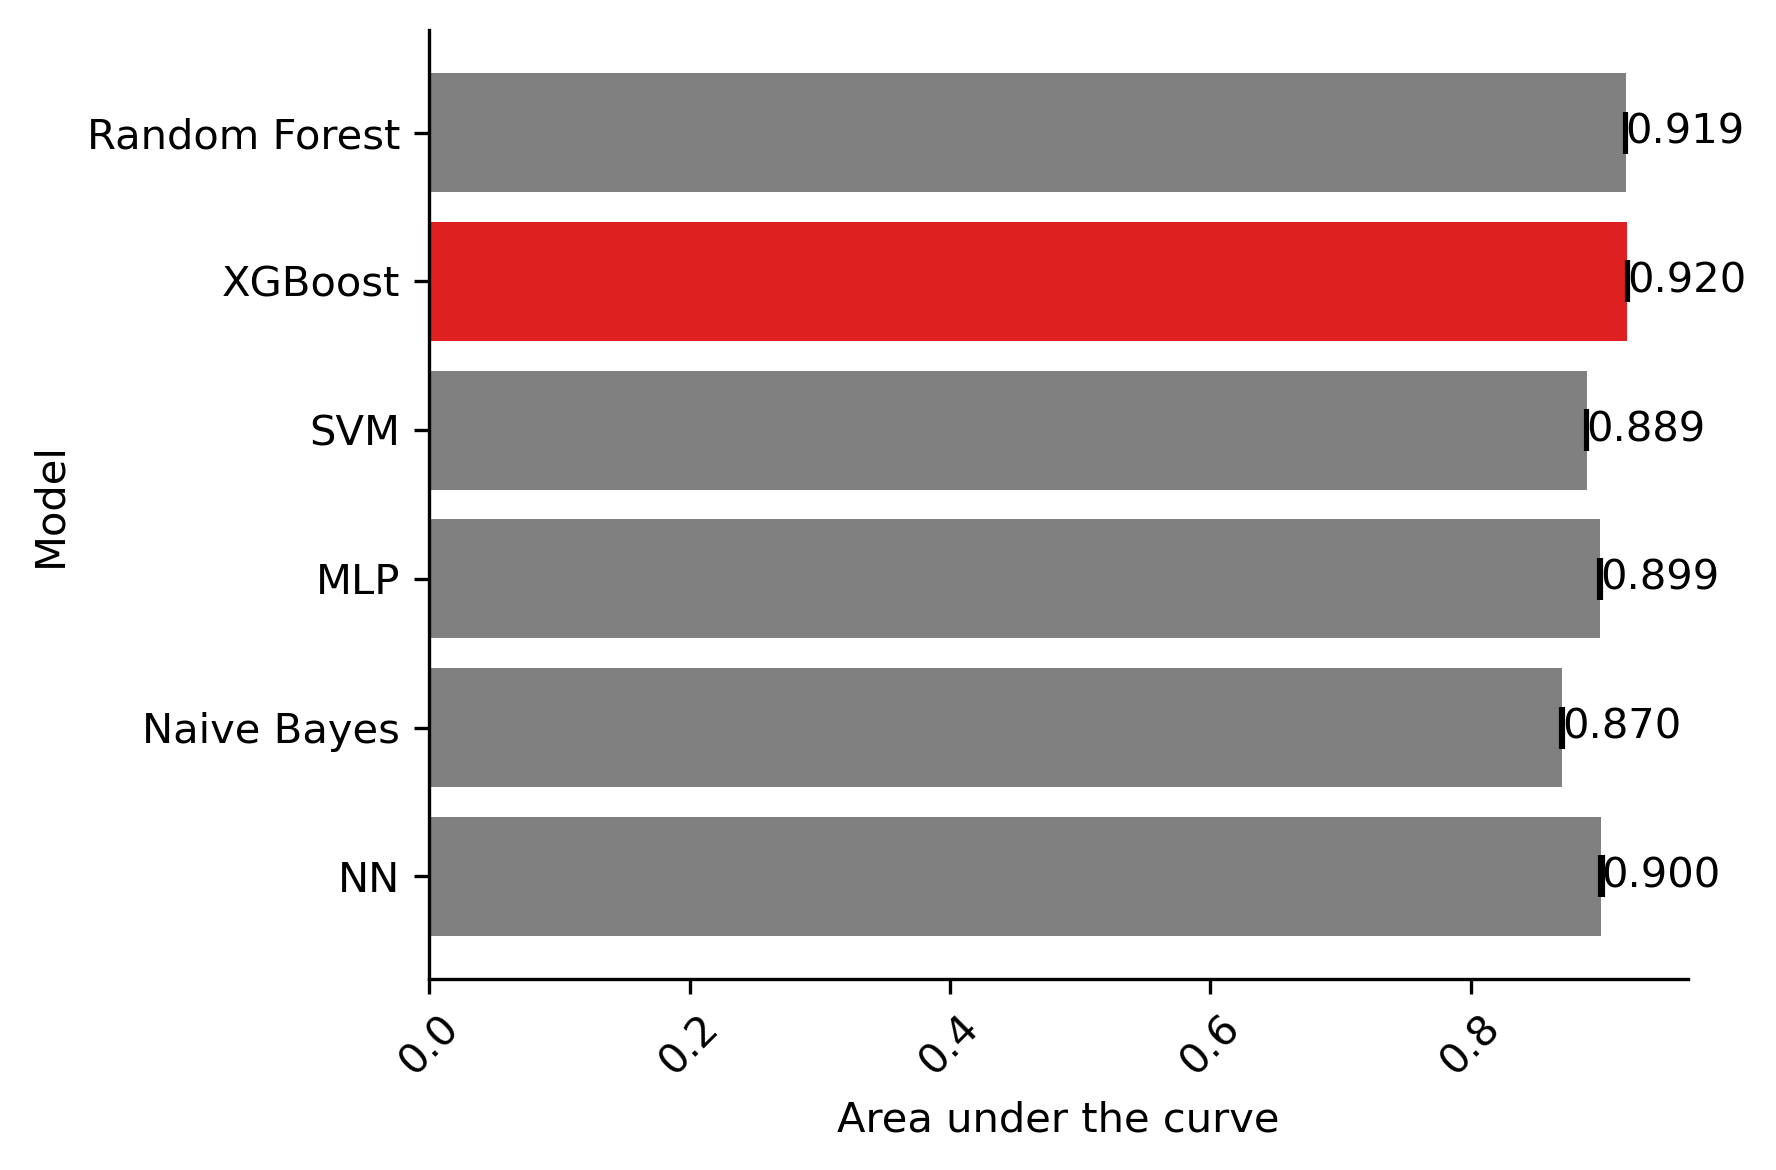

In [11]:
# Plot

colors = ["grey"] * len(auc_df)
colors[auc_df[auc_df["Model"] == "XGBoost"].index[0]] = "red"

# Create barplot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=auc_df, y='Model', x='AUC', ci=None, palette=colors)

# Add AUC values at the tips of the bars
for i, (auc, model) in enumerate(zip(auc_df['AUC'], auc_df['Model'])):
    ax.text(auc, i, f'{auc:.3f}', va='center')

# Add confidence intervals with error bars
auc_values = auc_df['AUC'].values
auc_ci_low = auc_df['AUC_CI_low'].values
auc_ci_high = auc_df['AUC_CI_high'].values
#plt.errorbar(y=range(len(auc_df)), x=auc_values, xerr=[auc_values - auc_ci_low, auc_ci_high - auc_values],
#             fmt='none', color='black', capsize=5)
plt.errorbar(y=range(len(models)), x=auc_values,xerr=[auc_ci_low, auc_ci_high], fmt='none', color='black', capsize=5)
# Customize plot
plt.xticks(rotation=45)
plt.xlabel('Area under the curve')
plt.ylabel('Model')
plt.tight_layout()
sns.despine()
plt.savefig('baseline_model_plot.png', dpi=400)


Accuracy: 0.8723


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.000, n=60, Accuracy: 87.54%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.003, n=59, Accuracy: 87.54%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.003, n=58, Accuracy: 87.28%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.004, n=57, Accuracy: 87.14%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.004, n=56, Accuracy: 87.58%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.004, n=55, Accuracy: 87.67%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.005, n=54, Accuracy: 87.28%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.005, n=53, Accuracy: 87.19%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.005, n=52, Accuracy: 87.28%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=51, Accuracy: 86.92%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=50, Accuracy: 86.97%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=49, Accuracy: 87.23%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=48, Accuracy: 87.32%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=47, Accuracy: 87.36%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=46, Accuracy: 87.41%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=45, Accuracy: 87.14%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=44, Accuracy: 87.49%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.006, n=43, Accuracy: 87.54%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=42, Accuracy: 87.28%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=41, Accuracy: 87.19%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=40, Accuracy: 87.36%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=39, Accuracy: 87.14%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=38, Accuracy: 87.41%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=37, Accuracy: 87.32%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=36, Accuracy: 87.67%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.007, n=35, Accuracy: 87.06%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.008, n=34, Accuracy: 87.28%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.008, n=33, Accuracy: 87.32%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.008, n=32, Accuracy: 87.10%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.009, n=31, Accuracy: 87.01%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.009, n=30, Accuracy: 86.92%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.009, n=29, Accuracy: 87.01%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.009, n=28, Accuracy: 86.97%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.010, n=27, Accuracy: 87.06%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.010, n=26, Accuracy: 87.10%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.011, n=25, Accuracy: 86.79%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.011, n=24, Accuracy: 86.22%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.011, n=23, Accuracy: 86.70%
Thresh=0.012, n=22, Accuracy: 85.70%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.012, n=21, Accuracy: 85.52%
Thresh=0.012, n=20, Accuracy: 85.52%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.012, n=19, Accuracy: 85.70%
Thresh=0.012, n=18, Accuracy: 85.61%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.013, n=17, Accuracy: 84.95%
Thresh=0.013, n=16, Accuracy: 85.34%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.013, n=15, Accuracy: 84.99%
Thresh=0.013, n=14, Accuracy: 85.13%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.016, n=13, Accuracy: 84.51%
Thresh=0.016, n=12, Accuracy: 84.69%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.016, n=11, Accuracy: 84.47%
Thresh=0.018, n=10, Accuracy: 84.12%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.020, n=9, Accuracy: 84.20%
Thresh=0.024, n=8, Accuracy: 83.24%
Thresh=0.035, n=7, Accuracy: 82.10%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.041, n=6, Accuracy: 82.19%
Thresh=0.042, n=5, Accuracy: 82.10%
Thresh=0.055, n=4, Accuracy: 80.39%


/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)


Thresh=0.082, n=3, Accuracy: 77.49%
Thresh=0.101, n=2, Accuracy: 77.58%
Thresh=0.163, n=1, Accuracy: 75.69%
AUC: 0.9206


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.000, n=60, AUC: 0.9206


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.003, n=59, AUC: 0.9206


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.003, n=58, AUC: 0.9206


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.004, n=57, AUC: 0.9200


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.004, n=56, AUC: 0.9200


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.004, n=55, AUC: 0.9201


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.005, n=54, AUC: 0.9191


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.005, n=53, AUC: 0.9205


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.005, n=52, AUC: 0.9236


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=51, AUC: 0.9198


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=50, AUC: 0.9204


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=49, AUC: 0.9188


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=48, AUC: 0.9204


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=47, AUC: 0.9227


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=46, AUC: 0.9185


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=45, AUC: 0.9189


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=44, AUC: 0.9214


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.006, n=43, AUC: 0.9190


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=42, AUC: 0.9208


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=41, AUC: 0.9208


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=40, AUC: 0.9240


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=39, AUC: 0.9230


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=38, AUC: 0.9233


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=37, AUC: 0.9193


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=36, AUC: 0.9252


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.007, n=35, AUC: 0.9242


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.008, n=34, AUC: 0.9237


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.008, n=33, AUC: 0.9259


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.008, n=32, AUC: 0.9240


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.009, n=31, AUC: 0.9231


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.009, n=30, AUC: 0.9251


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.009, n=29, AUC: 0.9226


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.009, n=28, AUC: 0.9220


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.010, n=27, AUC: 0.9257


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.010, n=26, AUC: 0.9215


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.011, n=25, AUC: 0.9188


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.011, n=24, AUC: 0.9200


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.011, n=23, AUC: 0.9200
Thresh=0.012, n=22, AUC: 0.9048


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.012, n=21, AUC: 0.9078
Thresh=0.012, n=20, AUC: 0.9043


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.012, n=19, AUC: 0.9035
Thresh=0.012, n=18, AUC: 0.9054


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.013, n=17, AUC: 0.9003
Thresh=0.013, n=16, AUC: 0.9004


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.013, n=15, AUC: 0.8967
Thresh=0.013, n=14, AUC: 0.8994


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.016, n=13, AUC: 0.8895
Thresh=0.016, n=12, AUC: 0.8865


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.016, n=11, AUC: 0.8825
Thresh=0.018, n=10, AUC: 0.8868
Thresh=0.020, n=9, AUC: 0.8879


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)


Thresh=0.024, n=8, AUC: 0.8771
Thresh=0.035, n=7, AUC: 0.8641
Thresh=0.041, n=6, AUC: 0.8651


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

Thresh=0.042, n=5, AUC: 0.8628
Thresh=0.055, n=4, AUC: 0.8566
Thresh=0.082, n=3, AUC: 0.8120
Thresh=0.101, n=2, AUC: 0.8080


/tmp/ipykernel_3187921/709973477.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Thresh=0.163, n=1, AUC: 0.7911


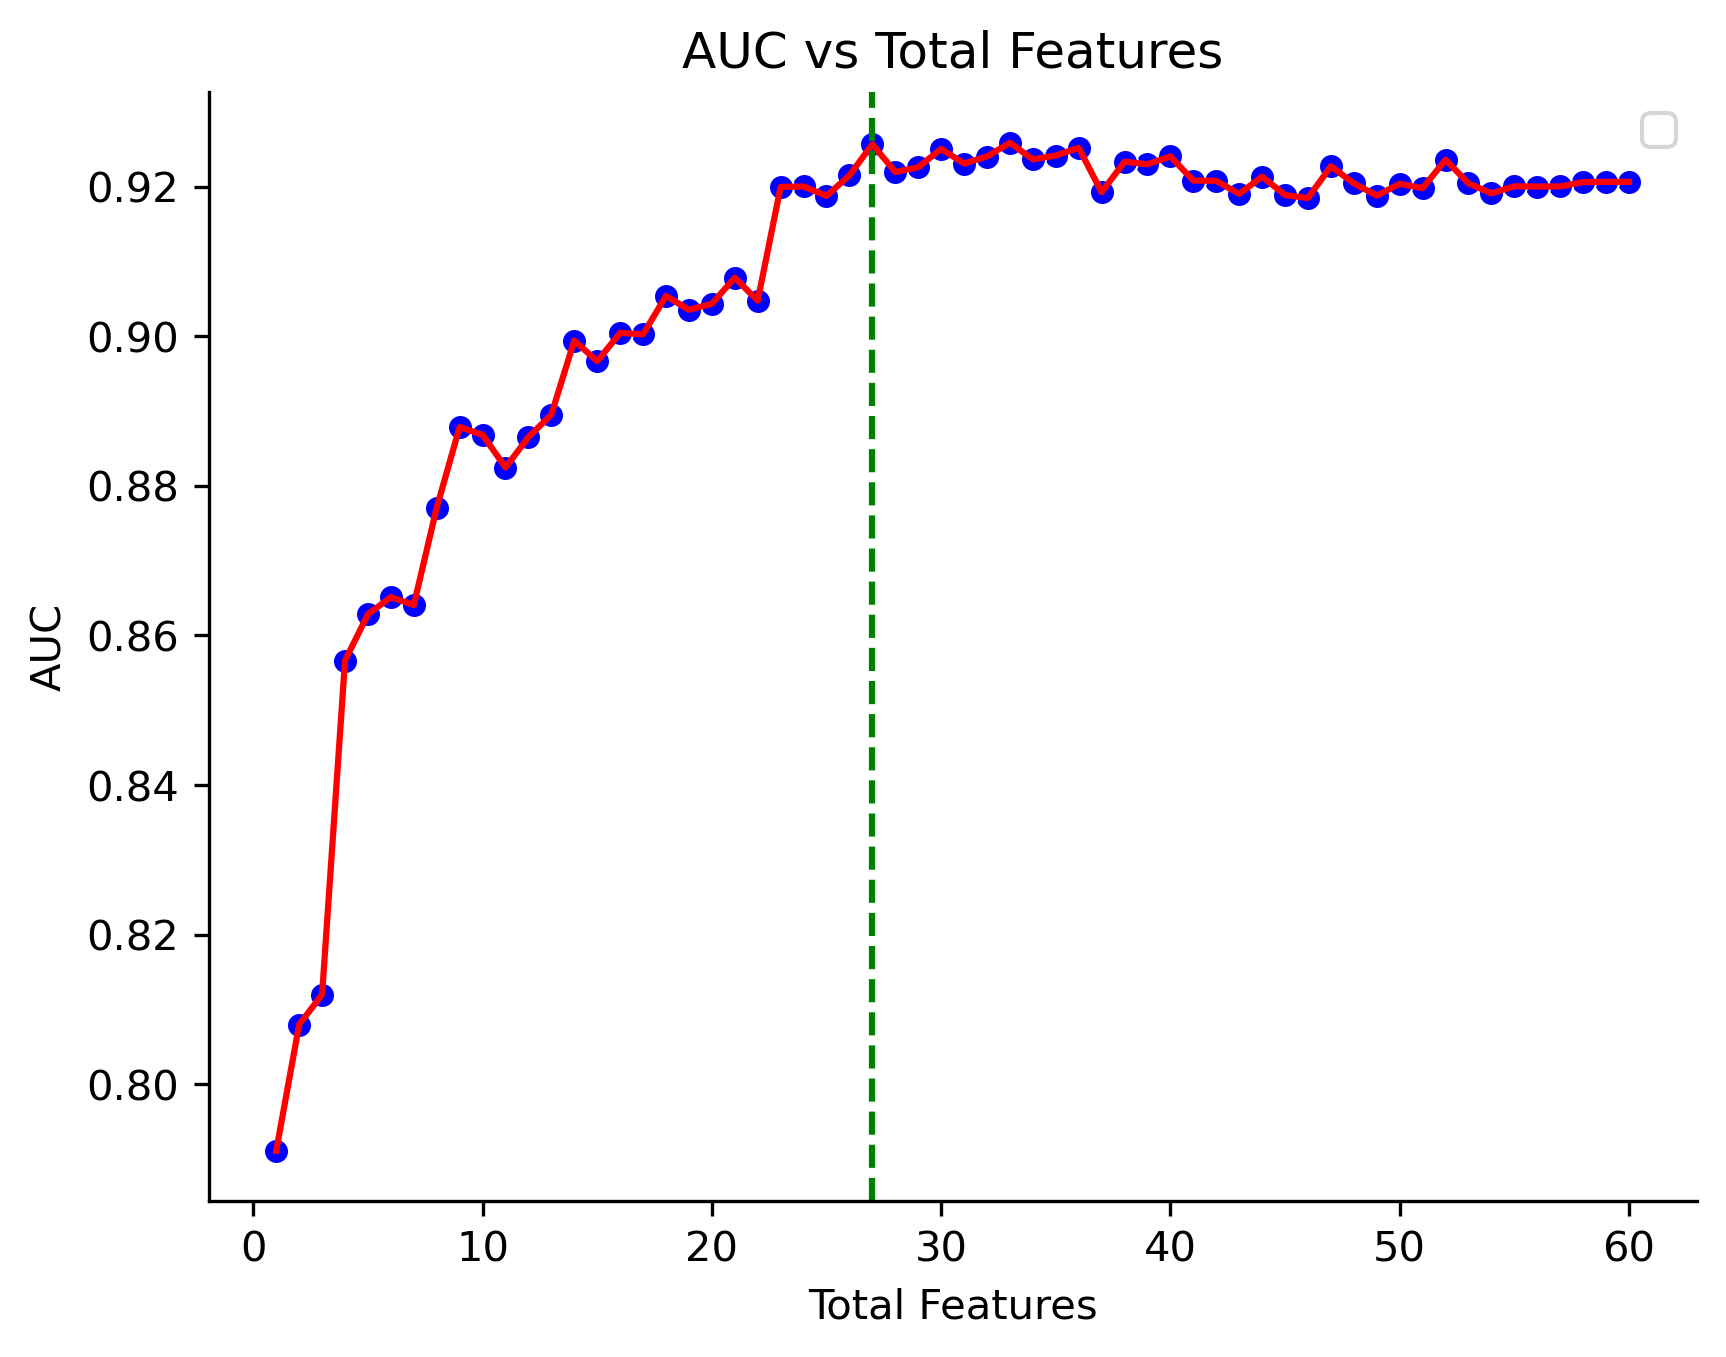

In [12]:
## Use XGboost to get most informative features
model = XGBClassifier()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
thresholds = np.sort(model.feature_importances_)

feature_df = pd.DataFrame(columns=['total_features', 'accuracy'])

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc:.4f}")

thresholds = np.sort(model.feature_importances_)

feature_df = pd.DataFrame(columns=['total_features', 'auc'])

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred_proba = selection_model.predict_proba(select_X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
    print("Thresh=%.3f, n=%d, AUC: %.4f" % (thresh, select_X_train.shape[1], auc))

# Plotting
sns.scatterplot(data=feature_df, x='total_features', y='auc', color='blue')
sns.lineplot(data=feature_df, x='total_features', y='auc', color='red')
plt.xlabel('Total Features')
plt.axvline(x=27, color='green', linestyle='--')
plt.ylabel('AUC')
plt.title('AUC vs Total Features')
plt.legend()

sns.despine()
plt.savefig('top_features_choice_plot.png', dpi=400)
plt.show()

/tmp/ipykernel_3187921/2276053647.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys', len(top_features))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


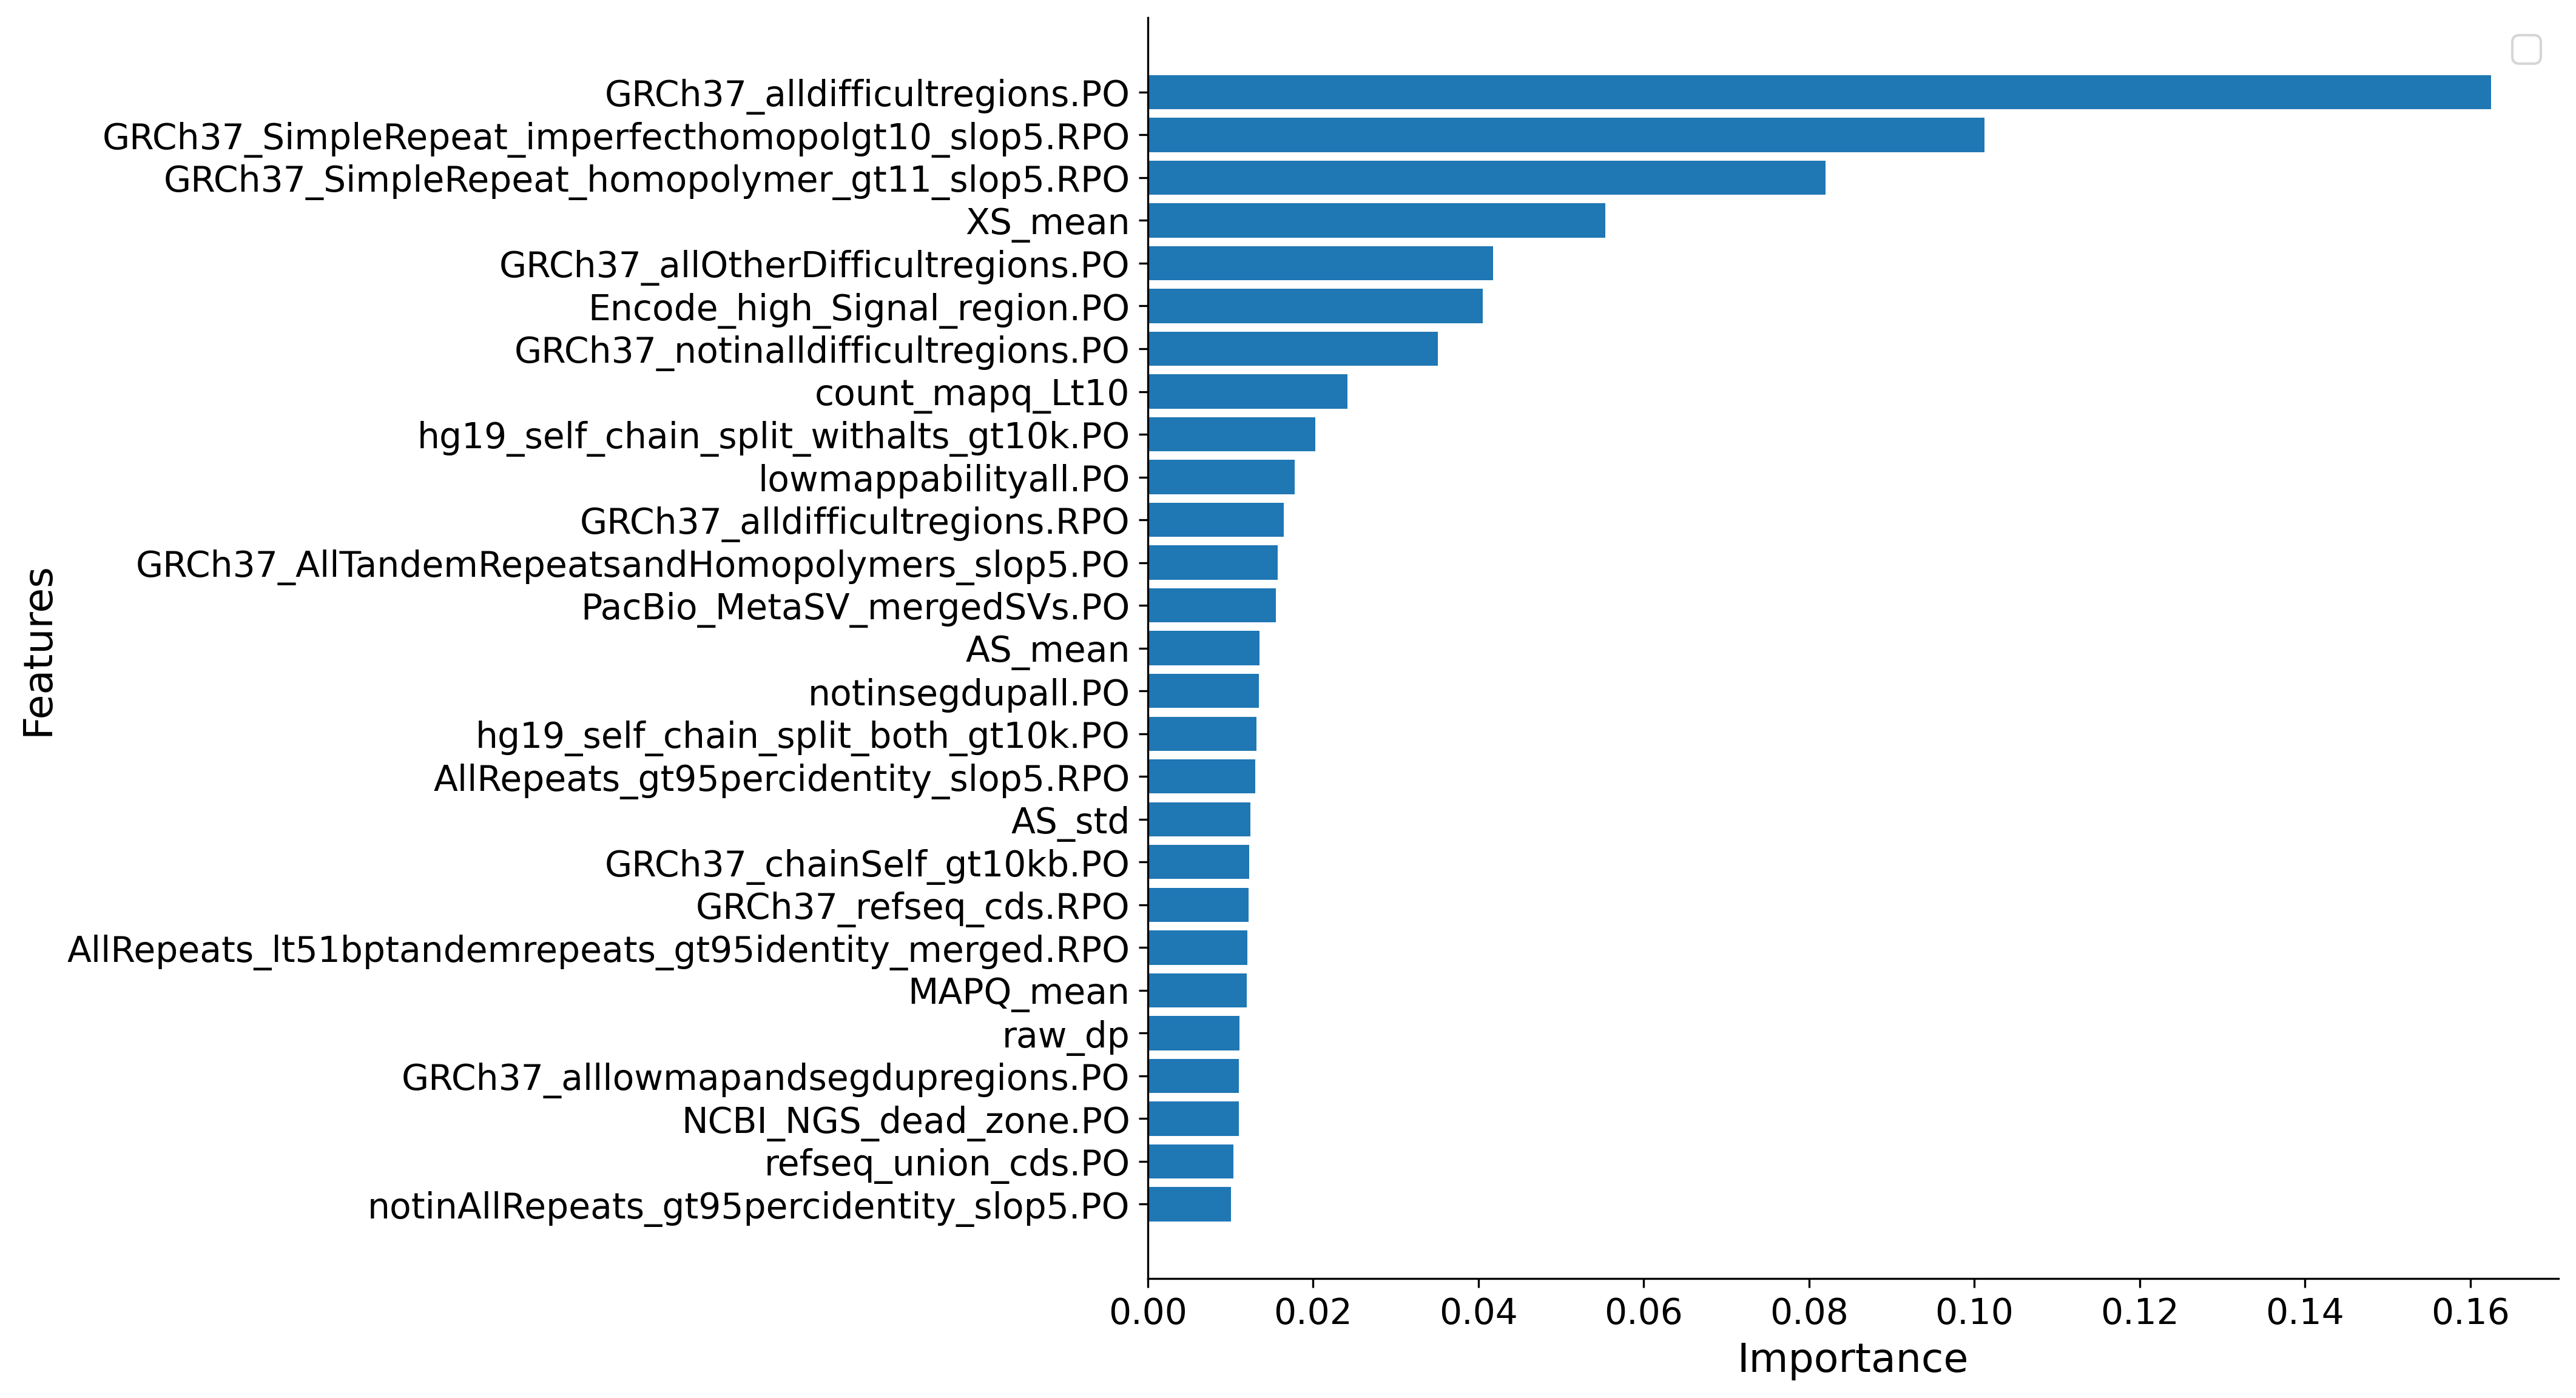

In [13]:

top_indices = np.argsort(model.feature_importances_)[::-1][:27]

# Get the names of the top 26 features based on their indices
top_features = data_filtered_df.columns[top_indices]
cmap = plt.cm.get_cmap('Greys', len(top_features))
# Get the importance scores of the top 26 features
top_importance = model.feature_importances_[top_indices]

# Create a bar plot
plt.figure(figsize=(10, 9))
plt.barh(top_features, top_importance)
#bars = plt.barh(top_features, top_importance, color=[cmap(i) for i in range(len(top_features))])
#plt.xlabel('Importance')
#plt.ylabel('Features')
plt.xlabel('Importance', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('Features', fontsize=16)
#plt.title('Top 26 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
# Adjust x and y axis labels size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
 # Adjust fontsize as needed
sns.despine()
# Show legend
plt.legend(fontsize=14)
plt.show()

In [14]:
data_filtered_top_df = data_filtered_df[top_features]
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(data_filtered_top_df, labels)
#X_train, X_test, y_train, y_test = preprocess_data(data_filtered_df, labels)
print(top_features)

Index(['GRCh37_alldifficultregions.PO',
       'GRCh37_SimpleRepeat_imperfecthomopolgt10_slop5.RPO',
       'GRCh37_SimpleRepeat_homopolymer_gt11_slop5.RPO', 'XS_mean',
       'GRCh37_allOtherDifficultregions.PO', 'Encode_high_Signal_region.PO',
       'GRCh37_notinalldifficultregions.PO', 'count_mapq_Lt10',
       'hg19_self_chain_split_withalts_gt10k.PO', 'lowmappabilityall.PO',
       'GRCh37_alldifficultregions.RPO',
       'GRCh37_AllTandemRepeatsandHomopolymers_slop5.PO',
       'PacBio_MetaSV_mergedSVs.PO', 'AS_mean', 'notinsegdupall.PO',
       'hg19_self_chain_split_both_gt10k.PO',
       'AllRepeats_gt95percidentity_slop5.RPO', 'AS_std',
       'GRCh37_chainSelf_gt10kb.PO', 'GRCh37_refseq_cds.RPO',
       'AllRepeats_lt51bptandemrepeats_gt95identity_merged.RPO', 'MAPQ_mean',
       'raw_dp', 'GRCh37_alllowmapandsegdupregions.PO',
       'NCBI_NGS_dead_zone.PO', 'refseq_union_cds.PO',
       'notinAllRepeats_gt95percidentity_slop5.PO'],
      dtype='object')


In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Choose hyperparameter domain to search over
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 15, 1, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
    'subsample': hp.quniform('subsample', 0.7, 0.9, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.01),

    'gamma': hp.quniform('gamma', 0, 0.5, 0.05),  # Additional hyperparameter
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1)),

    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'eval_metric': 'error',  # Use 'error' for classification task
}

def score(params):
    model = XGBClassifier(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}  # Minimize negative accuracy (maximize accuracy)
    
def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=150, trials=trials)
    return best

trials = Trials()
best_params = optimize(trials, space)
#XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
#              missing=nan, monotone_constraints='()', n_estimators=100,
#              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
#              reg_alpha=0, reg_lambda=1, ...#)

0.812637121544537                                                       
  0%|                           | 0/150 [00:00<?, ?trial/s, best loss=?]

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8038613426941641                                                      
0.800351031154015                                                       
0.8021061869240895                                                      
  3%| | 4/150 [00:00<00:17,  8.26trial/s, best loss: -0.812637121544537]

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8108819657744625                                                      
0.806494076349276                                                       
  3%| | 5/150 [00:00<00:16,  8.69trial/s, best loss: -0.812637121544537]

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8192189556823168                                                      
0.8113207547169812                                                      
  5%| | 7/150 [00:01<00:19,  7.50trial/s, best loss: -0.8192189556823168

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8095655989469065                                                      
0.812637121544537                                                       
  7%| | 10/150 [00:01<00:16,  8.35trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8113207547169812                                                      
0.8174637999122422                                                      
  7%| | 11/150 [00:01<00:17,  8.04trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8086880210618692                                                      
0.8104431768319439                                                      
0.8021061869240895                                                      
 10%| | 15/150 [00:01<00:16,  8.23trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8192189556823168                                                      
0.8135146994295743                                                      
 11%| | 17/150 [00:02<00:14,  8.99trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8117595436594998                                                      
 12%| | 18/150 [00:02<00:19,  6.69trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8078104431768319                                                      
0.8183413777972796                                                      
0.8135146994295743                                                      
 14%|▏| 21/150 [00:02<00:16,  7.99trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.813953488372093                                                       
0.8192189556823168                                                      
0.8179025888547609                                                      
 15%|▏| 23/150 [00:03<00:18,  6.82trial/s, best loss: -0.819218955682316

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8249232119350592                                                      
0.8060552874067574                                                      
0.8205353225098727                                                      
 18%|▏| 27/150 [00:03<00:14,  8.66trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8205353225098727                                                      
0.8025449758666081                                                      
 19%|▏| 29/150 [00:03<00:16,  7.46trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8069328652917946                                                      
0.8179025888547609                                                      
0.7999122422114963                                                      
 21%|▏| 32/150 [00:04<00:14,  8.34trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.812637121544537                                                       
0.8021061869240895                                                      
 23%|▏| 34/150 [00:04<00:15,  7.46trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8218516893374287                                                      
0.8012286090390522                                                      
0.8073716542343133                                                      
 25%|▏| 37/150 [00:04<00:13,  8.34trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8104431768319439                                                      
0.8091268100043879                                                      
 26%|▎| 39/150 [00:05<00:15,  7.31trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8021061869240895                                                      
0.8069328652917946                                                      
0.8091268100043879                                                      
 28%|▎| 42/150 [00:05<00:13,  8.29trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8047389205792014                                                      
0.8073716542343133                                                      
 29%|▎| 43/150 [00:05<00:15,  6.79trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8174637999122422                                                      
0.8100043878894252                                                      
0.8200965335673541                                                      
 31%|▎| 47/150 [00:06<00:11,  8.63trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.7999122422114963                                                      
0.8187801667397981                                                      
 32%|▎| 48/150 [00:06<00:14,  6.97trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.806494076349276                                                       
0.8121983326020185                                                      
 34%|▎| 51/150 [00:06<00:13,  7.26trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.815269855199649                                                       
0.8078104431768319                                                      
0.8192189556823168                                                      
 36%|▎| 54/150 [00:07<00:13,  6.97trial/s, best loss: -0.824923211935059

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8271171566476525                                                      
0.8165862220272049                                                      
0.8069328652917946                                                      
 38%|▍| 57/150 [00:07<00:11,  8.12trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8095655989469065                                                      
0.815269855199649                                                       
0.8091268100043879                                                      
 40%|▍| 60/150 [00:07<00:12,  7.45trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8016673979815708                                                      
0.812637121544537                                                       
0.8060552874067574                                                      
 42%|▍| 63/150 [00:08<00:10,  8.27trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8056164984642387                                                      
0.8236068451075033                                                      
 43%|▍| 65/150 [00:08<00:12,  7.02trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8236068451075033                                                      
0.8029837648091268                                                      
0.8218516893374287                                                      
 45%|▍| 68/150 [00:08<00:09,  8.41trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8135146994295743                                                      
0.8095655989469065                                                      
 47%|▍| 70/150 [00:09<00:11,  6.99trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8104431768319439                                                      
0.8121983326020185                                                      
0.8108819657744625                                                      
 49%|▍| 73/150 [00:09<00:09,  8.49trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8117595436594998                                                      
0.8082492321193506                                                      
0.8073716542343133                                                      
 51%|▌| 76/150 [00:09<00:10,  7.24trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8043001316366828                                                      
0.8192189556823168                                                      
0.812637121544537                                                       
 53%|▌| 79/150 [00:10<00:08,  8.31trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8121983326020185                                                      
0.8012286090390522                                                      
 54%|▌| 81/150 [00:10<00:09,  7.10trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8148310662571303                                                      
0.8007898200965335                                                      
0.8113207547169812                                                      
 56%|▌| 84/150 [00:11<00:09,  6.96trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8034225537516455                                                      
0.822729267222466                                                       
 57%|▌| 86/150 [00:11<00:10,  6.32trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8060552874067574                                                      
0.8183413777972796                                                      
 59%|▌| 88/150 [00:11<00:08,  7.49trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8244844229925405                                                      
0.7985958753839403                                                      
0.8218516893374287                                                      
 61%|▌| 91/150 [00:12<00:08,  6.99trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8209741114523914                                                      
0.8012286090390522                                                      
0.8007898200965335                                                      
 63%|▋| 94/150 [00:12<00:06,  8.09trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8157086441421676                                                      
0.7999122422114963                                                      
 64%|▋| 96/150 [00:12<00:08,  6.71trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8021061869240895                                                      
0.8205353225098727                                                      
0.8007898200965335                                                      
 66%|▋| 99/150 [00:13<00:06,  7.65trial/s, best loss: -0.827117156647652

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.799034664326459                                                       
0.8200965335673541                                                      
 67%|▋| 101/150 [00:13<00:07,  6.77trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.806494076349276                                                       
0.8021061869240895                                                      
0.7994734532689777                                                      
 69%|▋| 104/150 [00:13<00:05,  7.82trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8078104431768319                                                      
0.813953488372093                                                       
 71%|▋| 106/150 [00:14<00:06,  6.97trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.800351031154015                                                       
0.812637121544537                                                       
0.8161474330846863                                                      
 73%|▋| 109/150 [00:14<00:04,  8.26trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.7985958753839403                                                      
0.8086880210618692                                                      
 74%|▋| 111/150 [00:14<00:05,  6.89trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8179025888547609                                                      
0.8078104431768319                                                      
0.8056164984642387                                                      
 76%|▊| 114/150 [00:15<00:04,  8.38trial/s, best loss: -0.82711715664765

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8034225537516455                                                      
0.8275559455901711                                                      
 77%|▊| 116/150 [00:15<00:05,  6.74trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8012286090390522                                                      
0.8095655989469065                                                      
 79%|▊| 118/150 [00:15<00:04,  7.77trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8095655989469065                                                      
0.8117595436594998                                                      
0.812637121544537                                                       
 81%|▊| 121/150 [00:16<00:04,  6.75trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8016673979815708                                                      
0.7784115840280825                                                      
 82%|▊| 123/150 [00:16<00:03,  7.70trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8113207547169812                                                      
 83%|▊| 124/150 [00:16<00:03,  8.11trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8095655989469065                                                      
0.8091268100043879                                                      
 84%|▊| 126/150 [00:17<00:03,  6.53trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8069328652917946                                                      
0.8148310662571303                                                      
 85%|▊| 128/150 [00:17<00:02,  7.68trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8021061869240895                                                      
0.8205353225098727                                                      
0.7999122422114963                                                      
 87%|▊| 131/150 [00:17<00:02,  6.68trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8038613426941641                                                      
0.8113207547169812                                                      
0.7972795085563844                                                      
 89%|▉| 134/150 [00:18<00:02,  7.83trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.800351031154015                                                       
0.8056164984642387                                                      
 91%|▉| 136/150 [00:18<00:02,  6.81trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8108819657744625                                                      
0.800351031154015                                                       
0.822729267222466                                                       
 93%|▉| 139/150 [00:18<00:01,  8.23trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.812637121544537                                                       
0.8021061869240895                                                      
 94%|▉| 141/150 [00:19<00:01,  6.89trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8262395787626152                                                      
0.7999122422114963                                                      
0.8275559455901711                                                      
 96%|▉| 144/150 [00:19<00:00,  7.88trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8007898200965335                                                      
0.8275559455901711                                                      
 97%|▉| 146/150 [00:19<00:00,  6.55trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8275559455901711                                                      
0.8275559455901711                                                      
 99%|▉| 148/150 [00:20<00:00,  7.60trial/s, best loss: -0.82755594559017

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.8170250109697236                                                      
0.8121983326020185                                                      
100%|█| 150/150 [00:20<00:00,  7.31trial/s, best loss: -0.82755594559017


/projects/wangc/rohan/miniconda3/envs/llm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



In [16]:
best_params

{'colsample_bytree': 0.2,
 'gamma': 0.15000000000000002,
 'learning_rate': 0.03,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 185,
 'reg_alpha': 0.002365930487313124,
 'reg_lambda': 0.0007534113384069407,
 'subsample': 0.9}

In [17]:
def evaluate_xgboost_model(X_train, X_test, y_train, y_test, xg_best_trial_params):
    final_xg_model = XGBClassifier(**xg_best_trial_params)
    final_xg_model.fit(X_train, y_train)
    
    # Predict classes
    y_pred_train = final_xg_model.predict(X_train)
    y_pred_test = final_xg_model.predict(X_test)
    
    # Calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Save the trained model
    joblib.dump(final_xg_model, "best_xgb_model.NEW.joblib")
    
    return train_accuracy, test_accuracy

train_accuracy, test_accuracy = evaluate_xgboost_model(X_train, X_test, y_train, y_test, best_params)
test_accuracy

0.8415971917507679

In [18]:
data_test_df = pd.read_csv("../../SangerVariants_VerSamples_IDTProbes.400data.resutls.csv")
data_test_cols_df = data_test_df[model_cols]

data_test_cols_df = data_test_cols_df.fillna(0)
data_test_cols_df = data_test_cols_df[top_features]
data_test_cols_df

min_max_scaler = preprocessing.MinMaxScaler()
test_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(data_test_cols_df.values),
                              columns=data_test_cols_df.columns, index=data_test_cols_df.index)

test_data = test_scaled_df.values


loaded_model = joblib.load("best_xgb_model.NEW.joblib")
predictions = loaded_model.predict(test_data).tolist()
pred_probabilities = loaded_model.predict_proba(test_data).tolist()
data_test_df['prob_pred_1'] = [prob[1] for prob in pred_probabilities]
data_test_df['prob_pred_0'] = [prob[0] for prob in pred_probabilities]
data_test_df['prediction'] = predictions

data_test_df.to_csv('SangerVariants_VerSamples_IDTProbes.400data.resutls.csv')

In [19]:
data_test_df[['homology', 'prob_pred_1']]
homology = data_test_df['homology']
predictions = data_test_df['prob_pred_1']

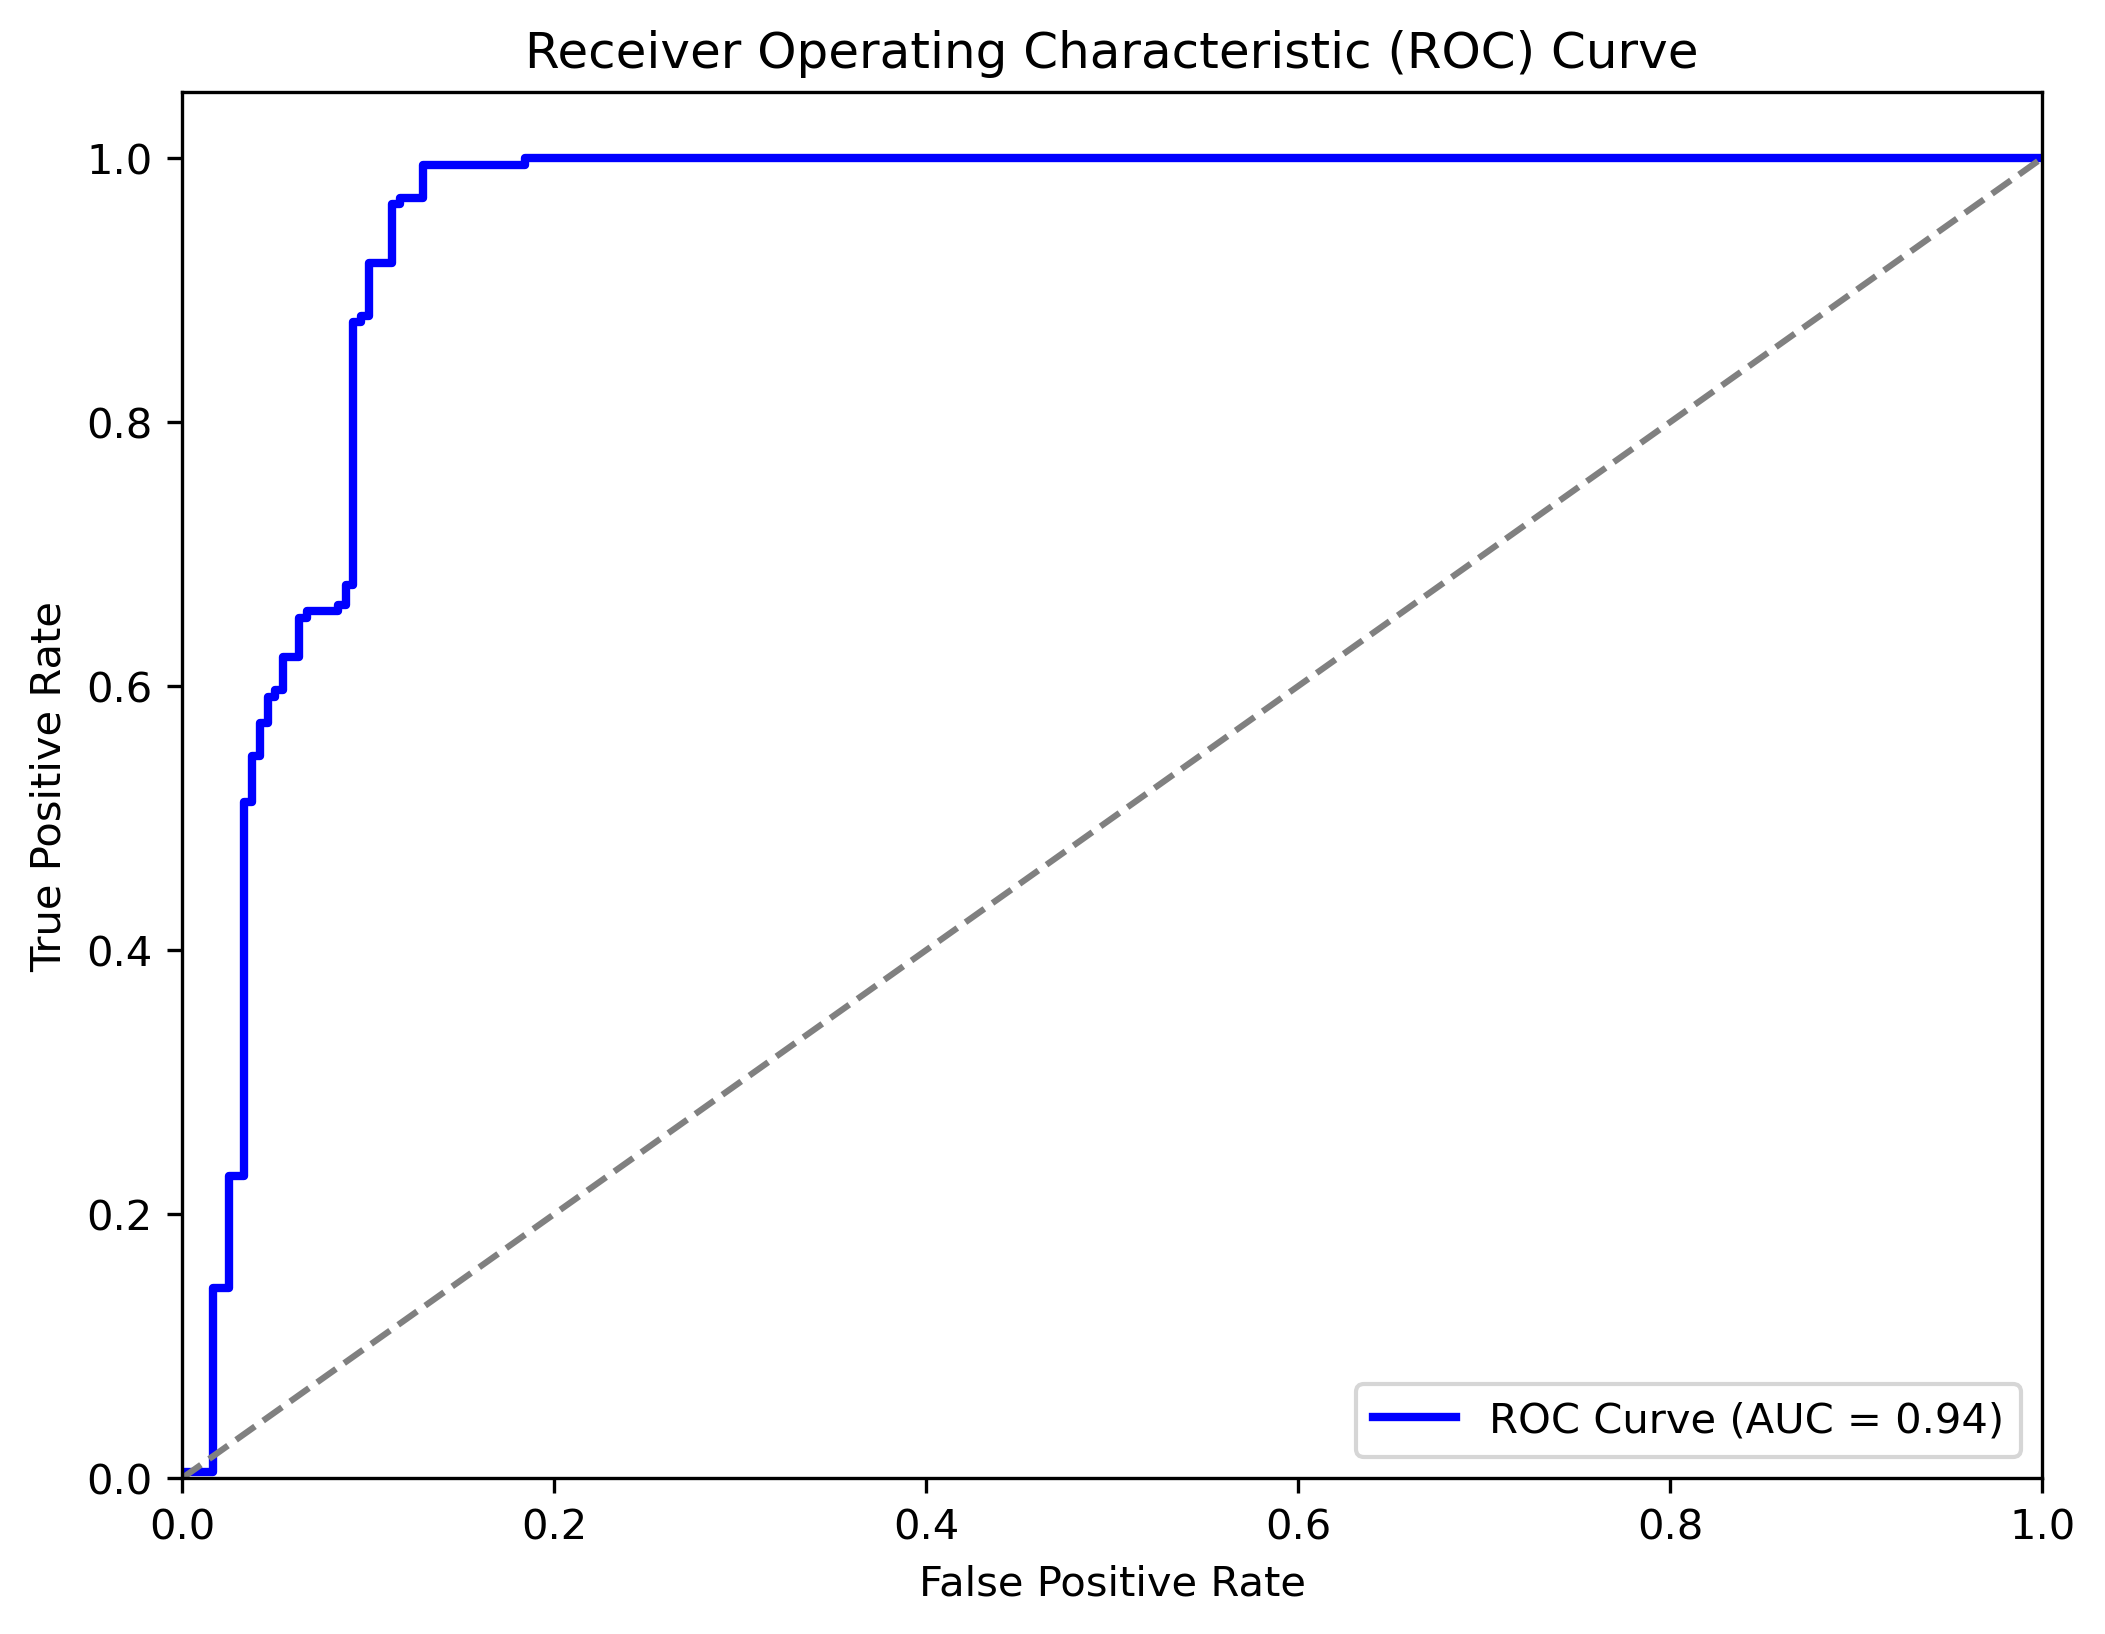

In [20]:
#Calculate ROC curve
fpr, tpr, thresholds = roc_curve(homology, predictions)

# Calculate AUC score
auc_score = roc_auc_score(homology, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

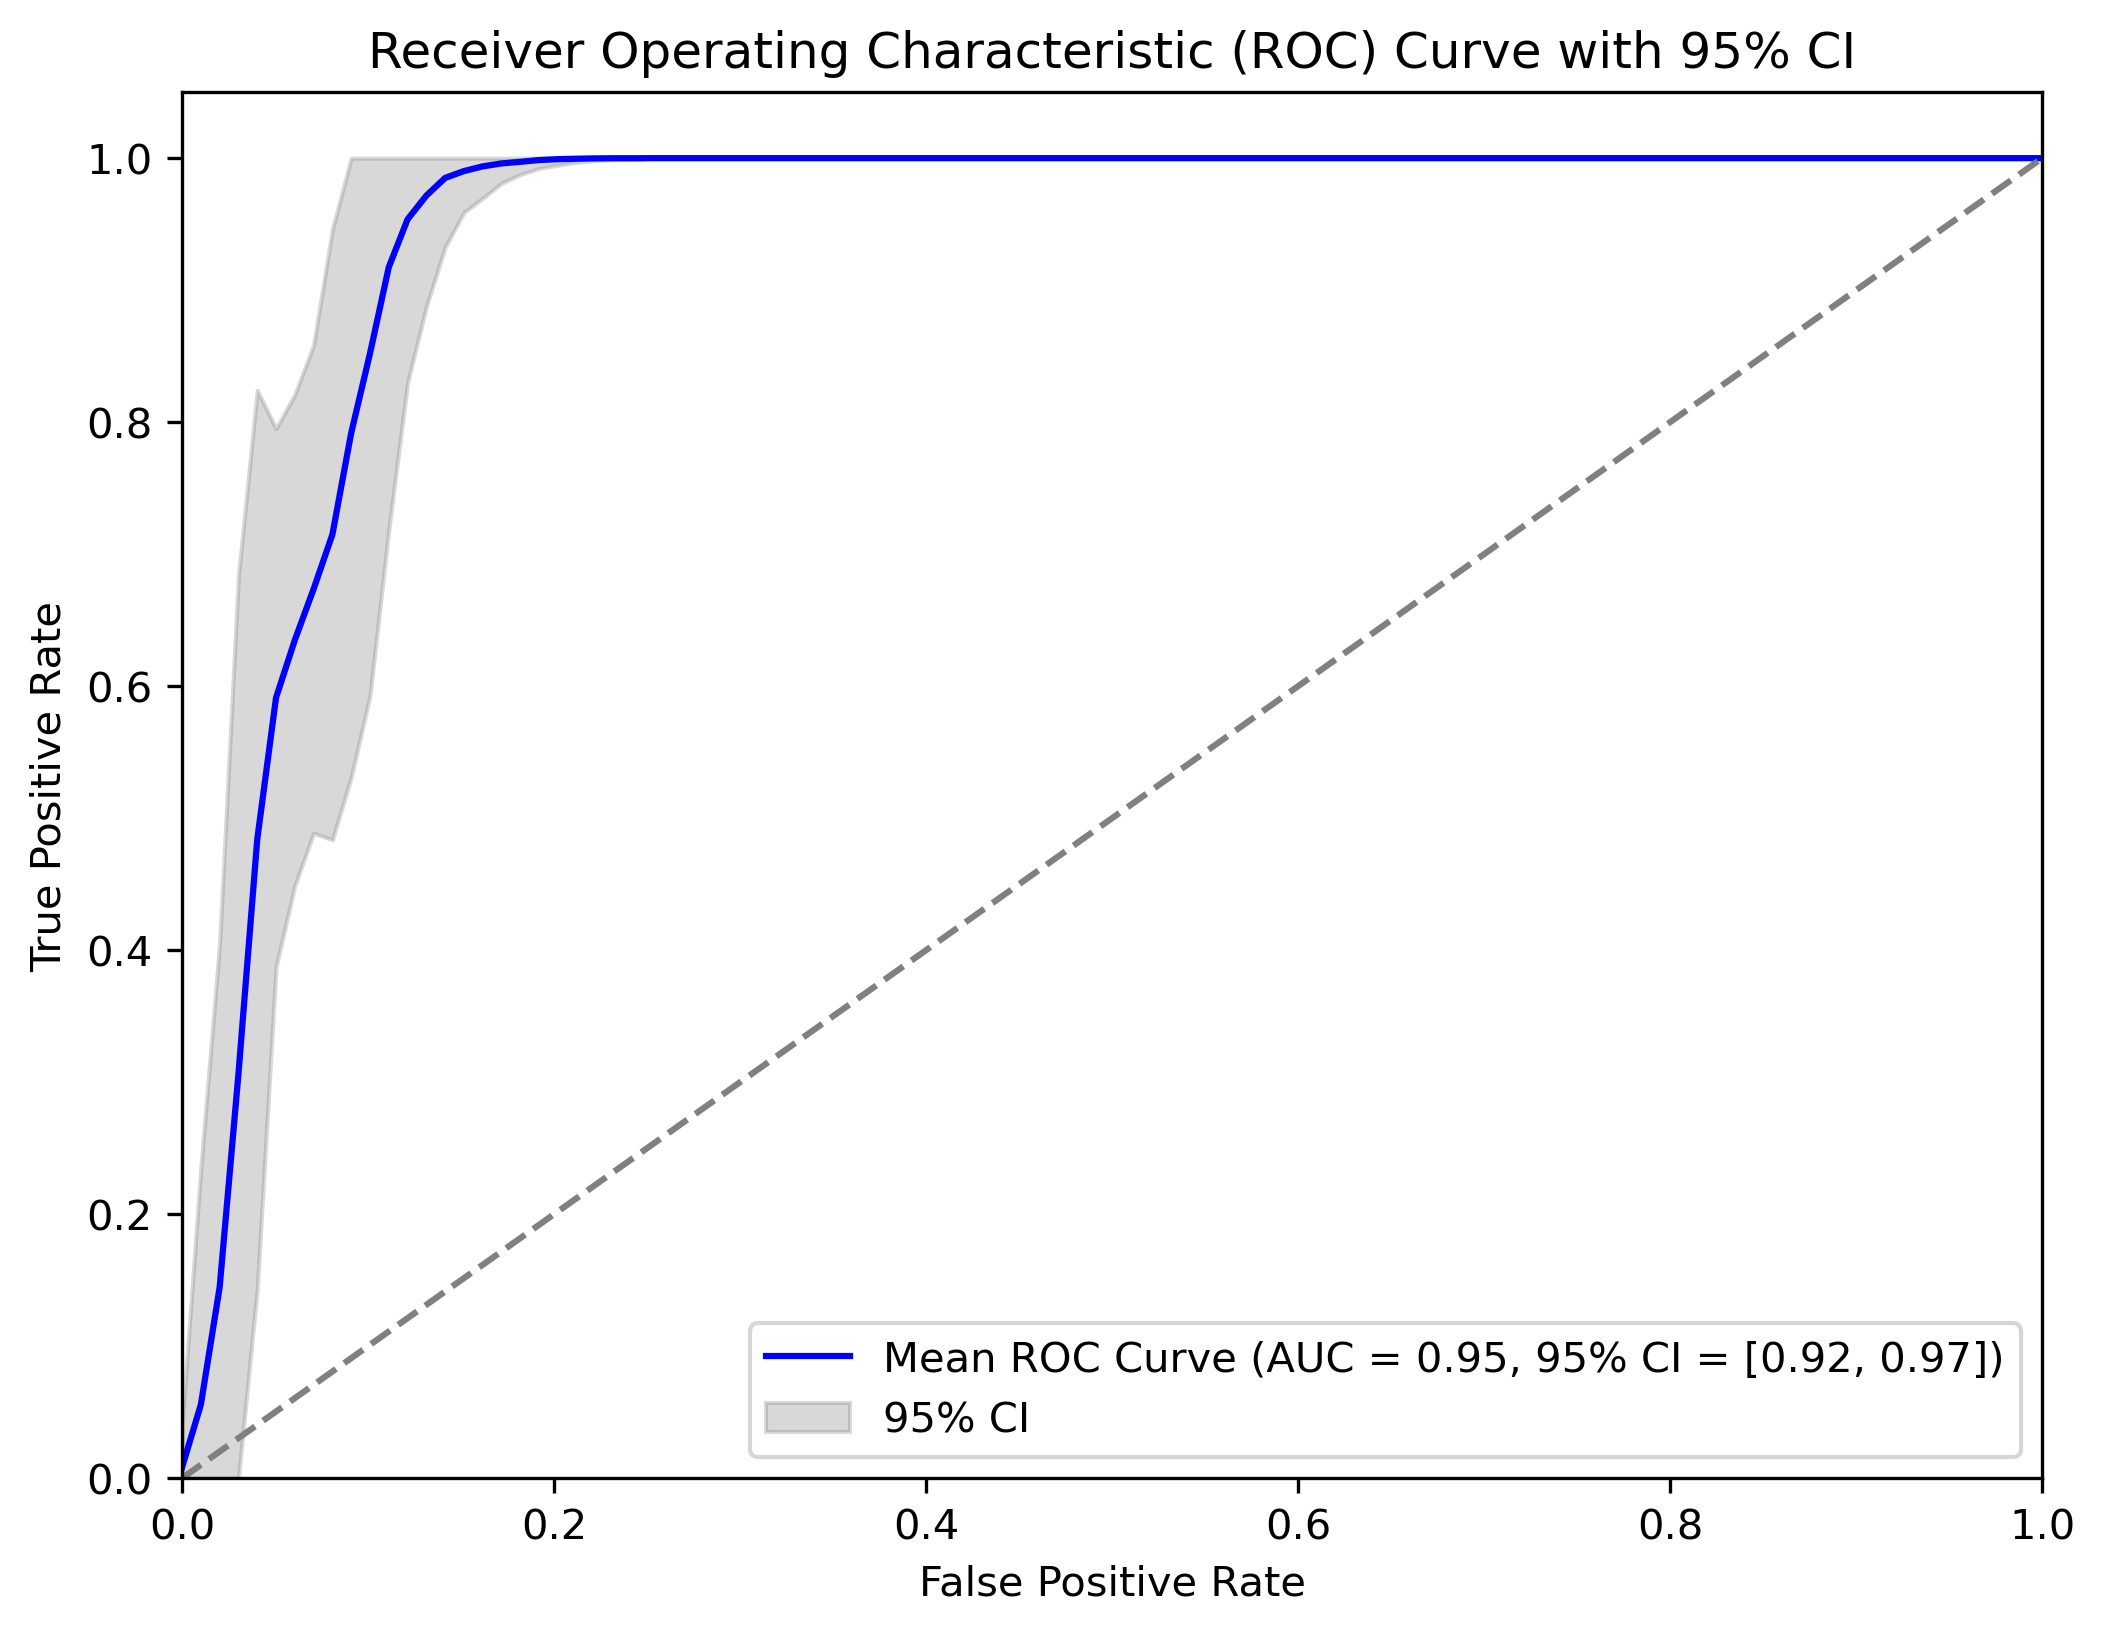

<Figure size 1920x1440 with 0 Axes>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

def plot_roc_with_ci(y_true, y_pred, n_bootstraps=100):
    # Compute ROC curve and ROC area for each bootstrap
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for _ in range(n_bootstraps):
        # Bootstrap sample
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        fpr, tpr, _ = roc_curve(y_true[idx], y_pred[idx])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Interpolate ROC curve to average FPR points
        interp_func = interp1d(fpr, tpr, bounds_error=False, fill_value=0)
        interp_tpr = interp_func(mean_fpr)
        tprs.append(interp_tpr)
    
    # Compute mean and CI of ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)
    
    # Compute mean AUC and CI
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    auc_ci = (mean_auc - 1.96 * std_auc, mean_auc + 1.96 * std_auc)
    
    # Plot ROC curve with CI
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC Curve (AUC = {mean_auc:.2f}, 95% CI = [{auc_ci[0]:.2f}, {auc_ci[1]:.2f}])')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label='95% CI')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve with 95% CI')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
plot_roc_with_ci(homology, predictions)
sns.despine()
plt.savefig('sanger_data_results_auc.png', dpi=400)
plt.show()

In [22]:
sensitivity = tpr
specificity = 1 - fpr

# Calculate Youden's J statistic for each threshold
youden_j = sensitivity + specificity - 1

# Find the index of the threshold that maximizes Youden's J statistic
best_threshold_index = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index]

# Calculate predictions at the best threshold
predictions_at_best_threshold = (predictions >= best_threshold).astype(int)

# Calculate accuracy at the best threshold
accuracy_at_best_threshold = accuracy_score(homology, predictions_at_best_threshold)

print("Accuracy at Best Threshold:", accuracy_at_best_threshold)

Accuracy at Best Threshold: 0.9272727272727272


In [23]:
data_result_df = data_test_df.copy()
data_result_df = data_result_df.drop(['prob_pred_0', 'prediction'], axis=1)
data_result_df['predictions'] = data_result_df['prob_pred_1'].apply(lambda x: 1 if x > 0.79318 else 0)
data_result_df.predictions.value_counts()

0    239
1    201
Name: predictions, dtype: int64

In [24]:
data_result_df.to_csv("SangerVariants_VerSamples_IDTProbes.400data.resutls.csv", index=None)